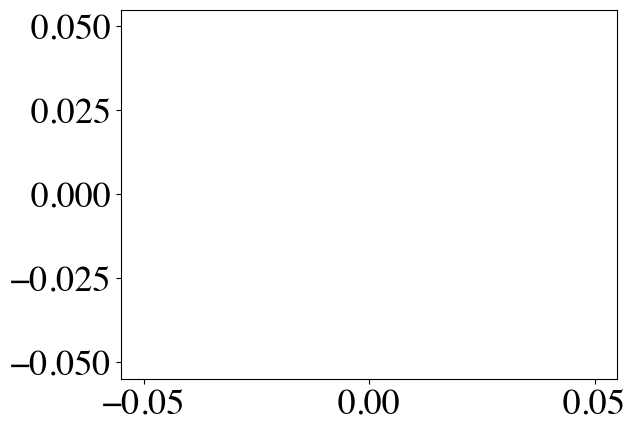

In [1]:
####### Imports and plotting utils definitions
## Modified from https://github.com/Chuneeta/beam_solver/blob/master/beam_solver/fits_utils.py

import numpy as np
from astropy.io import fits
from astropy.table import Table
from astropy import wcs
from astropy.cosmology import LambdaCDM
from astropy.wcs import WCS
import aplpy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import colors
from colormaps import spectral
from matplotlib.colors import ColorConverter
import warnings
from astropy.coordinates import AltAz, EarthLocation, SkyCoord
from astropy.time import Time
from astropy import units as u
from reproject import reproject_from_healpix
import glob
import healpy as hp
import os
import scipy
import pylab as pl
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from scipy import optimize
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter

# Font properties
# Note: TNR required for bolding due to font manager bug
# Math font for compact, times-like scientific notation
# Exit out of notebook before changing
times_font=True
if times_font:
    font_bold = fm.FontProperties(family='Times New Roman', style='normal', size=32, weight='bold', stretch='normal')
    font      = fm.FontProperties(family='Times', style='normal', size=14, weight='normal', stretch='normal')
    font_name ='Times'
    plt.rcParams["mathtext.fontset"] = "stixsans"
    plt.rcParams['font.family'] = 'Times'
else:
    font_name ='Dejavu Sans'
    font_bold = fm.FontProperties(family='Dejavu Sans', style='normal', size=14, weight='bold', stretch='normal')
    font      = fm.FontProperties(family='Dejavu Sans', style='normal', size=14, weight='normal', stretch='normal')  

# Set defaults for plot font and size
matplotlib.rc('font', size=26)
matplotlib.rc('axes', labelsize=26)    
    
# Color map
cb_spec, cb_spec_r = spectral()
cb_spec.set_bad('white')

# Colorbar
colorbar_scale_catalog = plt.pcolor([0,0], [0,0], [[0,0],[0,0]] ,norm=colors.Normalize(vmin=0, vmax=6000),
            cmap=cb_spec)#'Spectral_r')
colorbar_scale_nobeam = plt.pcolor([0,0], [0,0], [[0,0],[0,0]] ,norm=colors.Normalize(vmin=-6000, vmax=6000),
            cmap=cb_spec)#'Spectral_r')
colorbar_scale_inst = plt.pcolor([0,0], [0,0], [[0,0],[0,0]] ,norm=colors.Normalize(vmin=-50, vmax=50),
            cmap=cb_spec)#'Spectral_r')
colorbar_scale_data = plt.pcolor([0,0], [0,0], [[0,0],[0,0]] ,norm=colors.Normalize(vmin=-100, vmax=100),
            cmap=cb_spec)#'Spectral_r')

## Plotting parameters for colors and plot locations
# Spectral custom colors
ColorConverter.colors['e']=(94/256, 79/256, 162/256)
ColorConverter.colors['g']=(50/256, 136/256, 189/256)
ColorConverter.colors['h']=(102/256, 194/256, 165/256)
ColorConverter.colors['i']=(253/256, 174/256, 97/256) 
ColorConverter.colors['j']=(219/256, 55/256, 82/256)
    
# Utilities
def str_to_pixel(fitsfile):
    """
    Changes the units from the FHD standard of Jy/str to Jy/pixel given 
    the typical pixel size of a 2048x2048 full sky uv-plane
    """
    my_cosmo = LambdaCDM(67.8, 0.308, 0.692)
    str_to_pixel = (0.0559529*(np.pi/180))**2   
    str_to_beam = 2.1614375e-06
    data, hdr = fits.getdata(fitsfile, header=True)
    # Set missing data to nans to become white
    data[data==0] = np.nan
    fits.writeto(fitsfile.replace('.fits','.beam.fits'),\
        data[:,:]*str_to_pixel*1000., header=hdr, overwrite=True)
    
    return fitsfile.replace('.fits','.beam.fits')

def get_fitsinfo(fitsfile):
    """
    Extracts data and header information (metadata) from fits file
    fitsfile: Input fitsfile
    """
    data, hdr = fits.getdata(fitsfile, header=True)
    data = data.squeeze()
    freq = 182. #hdr ['CRVAL3']
    #nxaxis = hdr['NAXIS1']
    #nyaxis = hdr['NAXIS2']
    return {'data':data, 'hdr':hdr, 'freq':freq} #, 'nxaxis':nxaxis, 'nyaxis':nyaxis}

def del_keyword(fitsfile, key, outfits, overwrite=False):
    """
    Deleting keyword from the header of the fitsfile
    fitsfile: Input fitsfile
    key: Keyword to be added to the header
    outfits: Output fitsfile.
    overwrite: Overwrites any exisiting file. Default is False.
    """
    _info = get_fitsinfo(fitsfile)
    hdr = _info['hdr']
    assert key in hdr.keys(), "given key not present in the header"
    del hdr[key]
    fits.writeto(outfits, _info['data'], hdr, overwrite=overwrite)
    
def add_keyword(fitsfile, key, value, outfits, overwrite=False):
    """
    Adding a keyword to the header of the fitsfile
    fitsfile: Input fitsfile
    key: Keyword to be added to the header
    value: Value of the keyword
    outfits: Output fitsfile.
    overwrite: Overwrites any exisiting file. Default is False.
    """
    _info = get_fitsinfo(fitsfile)
    hdr = _info['hdr']
    hdr.append(key)
    hdr[key] = value
    fits.writeto(outfits, _info['data'], hdr, overwrite=overwrite)
    
def get_radec(fitsfile):
    _info = get_fitsinfo(fitsfile)
    hdr= _info['hdr']
    
    naxis1 = hdr['NAXIS1']
    naxis2 = hdr['NAXIS2']
    x = np.linspace(1, naxis1, naxis1)
    y = np.linspace(1, naxis2, naxis2)
    xx, yy = np.meshgrid(x, y)
    
    ### vstack: Stack arrays in sequence vertically (row wise).
    ## a = np.array([1, 2, 3])
    ## b = np.array([4, 5, 6])
    ## np.vstack((a,b))
    ## array([[1, 2, 3],
    ##       [4, 5, 6]])
    ### T: transpose
    ### reshape(-1): reshape to one dimension
    pixargs = np.vstack([xx.reshape(-1), yy.reshape(-1)]).T
    
    wcs = WCS(fitsfile)
    
    if wcs.has_spectral:
        freq = np.copy(xx.reshape(-1))
        freq[:] = 1
        pixargs = np.vstack([xx.reshape(-1), yy.reshape(-1), freq, freq]).T
        world = wcs.all_pix2world(pixargs, 1)
    else:
        pixargs = np.vstack([xx.reshape(-1), yy.reshape(-1)]).T
        world = wcs.all_pix2world(pixargs, 1)
    
    ra = world[:,0].reshape(naxis1,naxis1)
    dec = world[:,1].reshape(naxis1,naxis1)
    
    return ra, dec

def find_horizon(fitsfile):
    """
    Find the horizon in RA DEC for an observation so that it can be plotted
    """
    _info = get_fitsinfo(fitsfile)
    hdr = _info['hdr']
    
    mwa_alt = 377.827 #(MWA, from Tingay et al. 2013)#
    mwa_lat = -26.7033194 #(MWA, from Tingay et al. 2013)
    mwa_lon = 116.67081524 #(MWA, from Tingay et al. 2013)
    mwa_loc = EarthLocation(lat=mwa_lat*u.degree, lon=-mwa_lon*u.degree)
    obs_time = Time(hdr['MJD-OBS'], format='mjd')
    
    step_size = 10
    horizon_az = range(0,360,step_size)
    horizon_alt = [0] * int(360./step_size)
    horizon_coords_altaz = SkyCoord(alt=horizon_alt*u.degree, az=horizon_az*u.degree, \
                                    obstime=obs_time,location=mwa_loc, frame='altaz')
    
    horizon_coords_radec = horizon_coords_altaz.transform_to(frame='fk5')
    #ra = horizon_coords_radec.ra.deg
    #dec = horizon_coords_radec.dec.deg
    
    #neg_ra_inds = np.where(horizon_coords_radec.ra.deg > 180)[0]
    #ra[neg_ra_inds] = horizon_coords_radec.ra.deg[neg_ra_inds] - 360.
    
    #return ra, dec
    
    return horizon_coords_radec

def reproject_galaxy(fitsfile,samplefits):
    _info = get_fitsinfo(fitsfile)
    hdr = _info['hdr']
    data = _info['data']
    
    #Outputs from pygdsm are in galactic coordinates
    nside=2048
    pix_inds_subset = np.arange(hp.nside2npix(nside))
    l, b = hp.pix2ang(nside,pix_inds_subset,lonlat=True)
    cel_coords = SkyCoord(l*u.deg, b*u.deg, frame='fk5')
    ra_subset = cel_coords.icrs.ra.value
    dec_subset = cel_coords.icrs.dec.value

    l = cel_coords.galactic.l.value
    b = cel_coords.galactic.b.value
    outside_galactic_plane_inds = np.argwhere((b > 15) | (b < -15))
    data[outside_galactic_plane_inds] = 0

    _sampleinfo = get_fitsinfo(samplefits)
    samplehdr = _sampleinfo['hdr']

    reprojected_galaxy, footprint = reproject_from_healpix((data, 'fk5'), samplehdr, nested=False)
    fits.writeto(fitsfile.replace('.fits','.proj.fits'), reprojected_galaxy, samplehdr, overwrite=True)
 
    return fitsfile.replace('.fits','.proj.fits')

In [86]:
####### Presentation
## Plots for a gif of the full-sky galactic model from FHD with the beam


def gif_fitsfile(fitsfile_pre, cmap=cb_spec, vmin=None, vmax=None, height=None, width=None, savefig=False, figname=''):
    
    fitsfile = str_to_pixel(fitsfile_pre)
    _info = get_fitsinfo(fitsfile)
    hdr = _info['hdr']
    data = _info['data']
    _info_pre = get_fitsinfo(fitsfile_pre)
    data_pre = _info_pre['data']
    
    fontsize=26
    
    fig = plt.figure(figsize=(21,21))
    f1 = aplpy.FITSFigure(fitsfile, figure=fig, subplot=(1,2,1))
    f1.recenter(hdr['CRVAL1'], hdr['CRVAL2'], height=height, width=width)
    
    f1.show_colorscale(cmap=cmap, stretch='linear',vmin=vmin,vmax=vmax)
    f1.set_nan_color('darkcyan')
    f1.show_contour(np.abs(data_pre), levels=[0.00000001],colors='ghostwhite',linestyle=4)
    #f1.show_contour(np.abs(data), levels=[0.00000001],colors='white')
    
    f1.axis_labels.set_ytext('Declination (deg)')
    f1.axis_labels.set_xtext('Right Ascension (deg)')
    f1.tick_labels.set_xformat('dd')
    f1.tick_labels.set_font(size=18)
    f1.axis_labels.set_font(size=fontsize)
    f1.ticks.set_yspacing(10)
    f1.ticks.set_xspacing(40)
    f1.ticks.hide()
    f1.tick_labels.hide()
    f1.add_grid()
    f1.grid.set_color('ghostwhite')
    f1.grid.set_alpha(0.5)
    f1.grid.set_linewidth(2)
    f1.grid.set_linestyle('--')
    f1.add_colorbar(location='right')
    f1.colorbar.set_axis_label_text(r'Brightness [mJy/pixel]')
    f1.colorbar.set_font(size=18)
    f1.colorbar.set_axis_label_font(size=fontsize)
    a=plt.gca()
    a.tick_params(direction='in', color='k', which='both')

    plt.tight_layout()
     
    if savefig:
        plt.savefig(figname, bbox_inches='tight', dpi=128)
        plt.close()
    else:
        plt.show()


dir_plt = '/Users/nicholebarry/MWA/data/fits_iamges/data_galaxy_removal/I/'
#dir_plt = '/Users/nicholebarry/MWA/data/fits_iamges/galaxy_only/3072/xx/'

## Test on one file 
#gif_fitsfile(dir_plt + '1088289384_uniform_Dirty_I.fits', \
#              vmax=300,vmin=-300,height=40,width=40)

## Gif maker
files = glob.glob(dir_plt + '*uniform_Residual_I.fits')
for file in files:
    file_noext = os.path.splitext(file)[0]
    gif_fitsfile(file, \
                vmax=300,vmin=-300,height=40,width=40,savefig=True,figname=file_noext)
    #gif_fitsfile(file, \
    #              vmax=2,vmin=-2,height=114,width=114*1.3,savefig=True,figname=file_noext)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/Users/nicholebarry/miniconda3/envs/python_graphics/lib/python3.11/site-packages/astropy/visualization/wcsaxes/core.py:257: UserWarning: The following kwargs were not used by contour: 'linestyle'
  cset = super().contour(*args, **kwargs)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/Users/nicholebarry/miniconda3/envs/python_graphics/lib/python3.11/site-packages/astropy/visualization/wcsaxes/core.py:257: UserWarning: The following kwargs were not used by contour: 'linestyle'
  cset = super().contour(*args, **kwargs)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/Users/nicholebarry/miniconda3/envs/python_graphics/lib/python3.11/site-packages/astropy/visualization/wcsaxes/core.py:257: UserWarning: The following kwargs were not used by contour: 'linestyle'
  cset = super().contour(*args, **kwargs)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/Users/nichole

/Users/nicholebarry/miniconda3/envs/python_graphics/lib/python3.11/site-packages/astropy/visualization/wcsaxes/core.py:257: UserWarning: The following kwargs were not used by contour: 'linestyle'
  cset = super().contour(*args, **kwargs)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/Users/nicholebarry/miniconda3/envs/python_graphics/lib/python3.11/site-packages/astropy/visualization/wcsaxes/core.py:257: UserWarning: The following kwargs were not used by contour: 'linestyle'
  cset = super().contour(*args, **kwargs)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/Users/nicholebarry/miniconda3/envs/python_graphics/lib/python3.11/site-packages/astropy/visualization/wcsaxes/core.py:257: UserWarning: The following kwargs were not used by contour: 'linestyle'
  cset = super().contour(*args, **kwargs)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/Users/nicholebarry/miniconda3/envs/python_graphics/lib/python3.11/site-packages/a

In [148]:
####### Presentation
## Plots for a gif of the galactic source model on the same projection as FHD images


def gif_galacticimage(fitsfile, samplefits, cmap=cb_spec, vmin=None, vmax=None, imsz=None, savefig=False, figname=''):
    
    fitsfile = reproject_galaxy(fitsfile, samplefits)
    
    _info = get_fitsinfo(fitsfile)
    hdr = _info['hdr']
    data = _info['data']
    
    fig = plt.figure(figsize=(21,21))
    fontsize=26
    
    f1 = aplpy.FITSFigure(fitsfile, figure=fig, subplot=(1,2,1))
    f1.recenter(hdr['CRVAL1'], hdr['CRVAL2'], height=imsz, width=imsz*1.3)
    
    f1.show_colorscale(cmap=cmap, stretch='linear',vmin=vmin,vmax=vmax)
    f1.set_nan_color('darkcyan')
    f1.show_contour(np.abs(data), levels=[0.00000001],colors='ghostwhite',linestyle=4)
    f1.show_markers(266.416833333, -29.0078055556,marker="*",c="blue",s=300)
    
    
    f1.axis_labels.set_ytext('Declination (deg)')
    f1.axis_labels.set_xtext('Right Ascension (deg)')
    f1.tick_labels.set_xformat('dd')
    f1.tick_labels.set_font(size=18)
    f1.axis_labels.set_font(size=fontsize)
    f1.ticks.set_yspacing(10)
    f1.ticks.set_xspacing(40)
    f1.ticks.hide()
    f1.tick_labels.hide()
    f1.add_grid()
    f1.grid.set_color('ghostwhite')
    f1.grid.set_alpha(0.5)
    f1.grid.set_linewidth(2)
    f1.grid.set_linestyle('--')
    f1.add_colorbar(location='right')
    f1.colorbar.set_axis_label_text(r'Brightness [Jy/pixel]')
    f1.colorbar.set_font(size=18)
    f1.colorbar.set_axis_label_font(size=fontsize)
    a=plt.gca()
    a.tick_params(direction='in', color='k', which='both')
    
    plt.tight_layout()
        
    if savefig:
        plt.savefig(figname, bbox_inches='tight', dpi=128)
        plt.close()
    else:
        plt.show()

file = '/Users/nicholebarry/MWA/data/EDA2/EDA2_159MHz_I_wPriori_mono_2049.fits'


dir_plt = '/Users/nicholebarry/MWA/data/fits_iamges/galaxy_only/3072/nobeam/xx/'
samplefiles = glob.glob(dir_plt + '*XX.fits')

for samplefile in samplefiles:
    file_noext = os.path.splitext(samplefile)[0] +'_galactic'
    gif_galacticimage(file, samplefile, vmax=1000,vmin=0,imsz=114,savefig=True,figname=file_noext)



In [128]:
####### Presentation
## Plots for a gif of the full-sky galactic model from FHD with the tapered beam


def plot_fitsfile(fitsfile, cmap=cb_spec, vmin=None, vmax=None, imsz=None, savefig=False, figname=''):
    
    fitsfile = str_to_beam(fitsfile)
    _info = get_fitsinfo(fitsfile)
    hdr = _info['hdr']
    data = _info['data']
    
    fontsize=26
    
    fig = plt.figure(figsize=(21,21))
    f1 = aplpy.FITSFigure(fitsfile, figure=fig, subplot=(1,2,1))
    f1.recenter(hdr['CRVAL1'], hdr['CRVAL2'], height=imsz, width=imsz)
    f1.show_colorscale(cmap=cmap, stretch='linear',vmin=vmin,vmax=vmax)
    f1.show_contour(np.abs(data), levels=[0.00000001],colors='white')
    f1.axis_labels.set_ytext('Declination (deg)')
    f1.axis_labels.set_xtext('Right Ascension (deg)')
    f1.tick_labels.set_xformat('dd')
    f1.tick_labels.set_font(size=18)
    f1.axis_labels.set_font(size=fontsize)
    f1.ticks.set_yspacing(10)
    f1.ticks.set_xspacing(40)
    f1.ticks.hide()
    f1.tick_labels.hide()
    f1.add_grid()
    f1.add_colorbar(location='right')
    f1.colorbar.set_axis_label_text(r'Brightness [mJy/pixel]')
    f1.colorbar.set_font(size=fontsize)
    f1.colorbar.set_axis_label_font(size=22)
    a=plt.gca()
    a.tick_params(direction='in', color='k', which='both')

    plt.tight_layout()
     
    if savefig:
        plt.savefig(figname, bbox_inches='tight', dpi=128)
        plt.close()
    else:
        plt.show()


dir_plt = '/Users/nicholebarry/MWA/data/fits_iamges/galaxy_only/tapered/yy/'
#plot_fitsfile(dir_plt + '1088281088_uniform_Model_XX.fits', \
#              vmax=12,vmin=-8,imsz=114)
files = glob.glob(dir_plt + '*YY.fits')

for file in files:
    file_noext = os.path.splitext(file)[0]
    plot_fitsfile(file, \
                  vmax=3,vmin=-1,imsz=114,savefig=True,figname=file_noext)

In [13]:
####### Presentation
####### Plot of the data improving with GP and with removing galaxy


def plot_showbeamimprovement(fitsfile_pre, cmap=cb_spec, vmin=None, vmax=None, imsz=None, width=None, \
                             savefig=False, fontsize=None, figname=''):
    
    fitsfile = str_to_pixel(fitsfile_pre)
    _info = get_fitsinfo(fitsfile)
    hdr = _info['hdr']
    data = _info['data']

    _info_pre = get_fitsinfo(fitsfile_pre)
    data_pre = _info_pre['data']
    
    fig = plt.figure(figsize=(21,21))
    f1 = aplpy.FITSFigure(fitsfile, figure=fig, subplot=(1,2,1))
    f1.recenter(hdr['CRVAL1'], hdr['CRVAL2'], height=imsz, width=width)
    
    f1.show_colorscale(cmap=cmap, stretch='linear',vmin=vmin,vmax=vmax)
    f1.set_nan_color('cadetblue')
    f1.show_contour(np.abs(data_pre), levels=[0.00000001],colors='white')
    
    f1.axis_labels.set_ytext('Declination (deg)')
    f1.axis_labels.set_xtext('Right Ascension (deg)')
    f1.tick_labels.set_xformat('dd')
    f1.tick_labels.set_font(size=18)
    f1.axis_labels.set_font(size=fontsize)
    f1.ticks.set_yspacing(10)
    f1.ticks.set_xspacing(40)
    f1.ticks.hide()
    f1.tick_labels.hide()
    f1.add_grid()
    f1.add_colorbar(location='right')
    f1.colorbar.set_axis_label_text(r'Brightness [mJy/pixel]')
    f1.colorbar.set_font(size=fontsize)
    f1.colorbar.set_axis_label_font(size=fontsize)
    a=plt.gca()
    a.tick_params(direction='in', color='k', which='both')

    plt.tight_layout()
     
    if savefig:
        plt.savefig(figname, bbox_inches='tight', dpi=300)
        plt.close()
    else:
        plt.show()


# dir_plt = '/Users/nicholebarry/MWA/data/fits_iamges/beam_showcase/'
# files = [dir_plt + '1088285600_uniform_Residual_YY_regbeam.fits',\
#          dir_plt + '1088285600_uniform_Residual_YY_GLEAM_without_gp.fits',\
#          dir_plt + '1088285600_uniform_Residual_YY_GLEAM_without_gp.fits',\
#          dir_plt + '1088285600_uniform_Residual_YY_si_gp15.fits']
# imsz = [114/2,114/2,114/2,114/2]
# width = [114/2,114/2,114,114]
# fontsize=[26,26,18,18]
# i=0


dir_plt = '/Users/nicholebarry/MWA/data/fits_iamges/data_galaxy_removal/yy/'
files = [dir_plt + '/extragalactic/1088285600_robust1_Residual_YY.fits',\
          dir_plt + '/galactic_extragalactic/1088285600_robust1_Residual_YY.fits']
#          dir_plt + '1088285600_uniform_Residual_YY_GLEAM_without_gp.fits',\
#          dir_plt + '1088285600_uniform_Residual_YY_GLEAM_without_gp.fits',\
#          dir_plt + '1088285600_uniform_Residual_YY_si_gp15.fits']
imsz = [114/2,114/2,114/2,114/2]
#imsz = [114/2,114/2,114/2,114/2]
#width = [114/2,114/2,114,114]
width = [114,114]
fontsize=[26,26,18,18]
i=0

#vmax=100,vmin=-100,imsz=114*1.2/3, width=114*2.49/4,  #vmax=6,vmin=-1

for file in files:
    file_noext = os.path.splitext(file)[0] + str(i)
    plot_showbeamimprovement(file, \
                  vmax=100,vmin=-100,imsz=imsz[i], width=width[i], fontsize=fontsize[i], savefig=True,figname=file_noext)
    i= i + 1

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


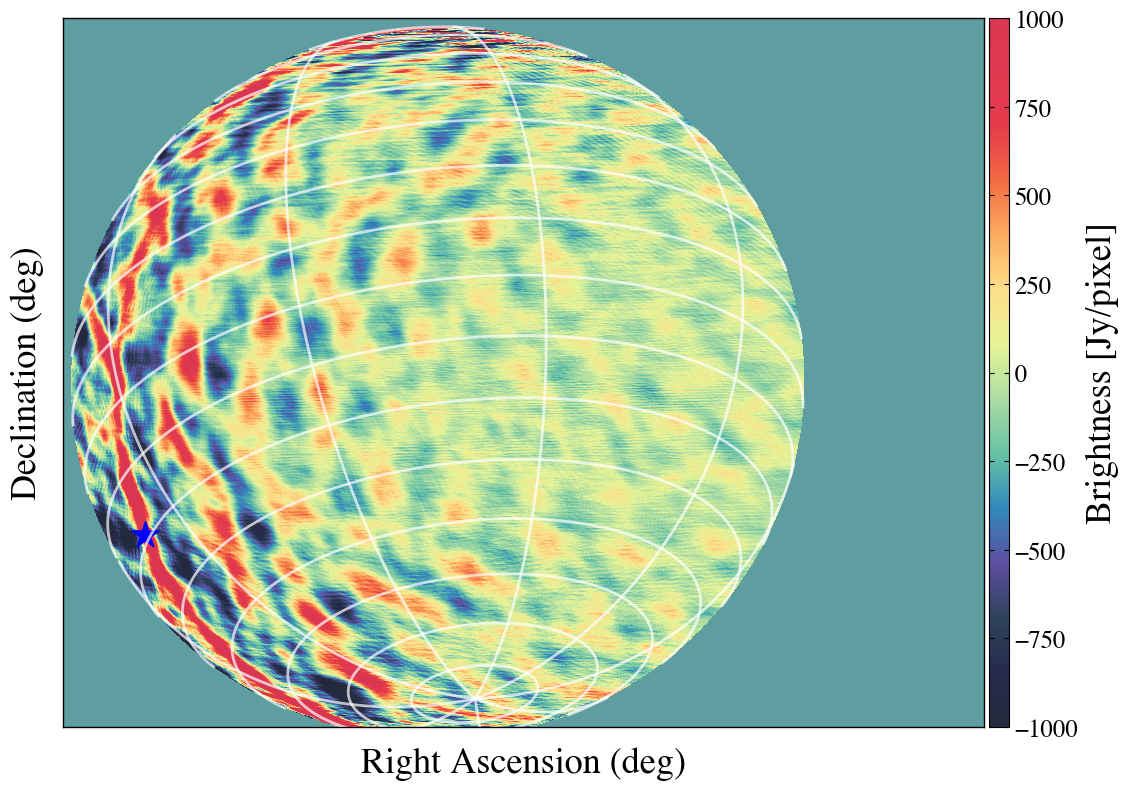

In [83]:
####### Presentation
## Plots for a gif of the full-sky galactic model through FHD with beam value 1


def plot_nobeam(fitsfile, cmap=cb_spec, vmin=None, vmax=None, imsz=None, savefig=False, figname=''):
    
    fitsfile = str_to_pixel(fitsfile)
    _info = get_fitsinfo(fitsfile)
    hdr = _info['hdr']
    data = _info['data']/1000.
    
    fontsize=26
    
    fig = plt.figure(figsize=(21,21))
    f1 = aplpy.FITSFigure(fitsfile, figure=fig, subplot=(1,2,1))
    f1.recenter(hdr['CRVAL1'], hdr['CRVAL2'], height=imsz, width=1.3*imsz)
    

    f1.show_colorscale(cmap=cmap, stretch='linear',vmin=vmin,vmax=vmax)
    f1.set_nan_color('cadetblue')
    f1.show_contour(np.abs(data), levels=[0.00000001],colors='white')

    f1.show_markers(266.416833333, -29.0078055556,marker="*",c="blue",s=400)
    f1.axis_labels.set_ytext('Declination (deg)')
    f1.axis_labels.set_xtext('Right Ascension (deg)')
    f1.tick_labels.set_xformat('dd')
    f1.tick_labels.set_font(size=18)
    f1.axis_labels.set_font(size=fontsize)
    f1.ticks.set_yspacing(10)
    f1.ticks.set_xspacing(40)
    f1.ticks.hide()
    f1.tick_labels.hide()
    f1.add_grid()
    f1.grid.set_color('white')
    f1.grid.set_alpha(0.7)
    f1.grid.set_linewidth(2)
    f1.add_colorbar(location='right')
    f1.colorbar.set_axis_label_text(r'Brightness [Jy/pixel]')
    f1.colorbar.set_font(size=18)
    f1.colorbar.set_axis_label_font(size=fontsize)
    a=plt.gca()
    a.tick_params(direction='in', color='k', which='both')

    plt.tight_layout()
     
    if savefig:
        plt.savefig(figname, bbox_inches='tight', dpi=128)
        plt.close()
    else:
        plt.show()


dir_plt = '/Users/nicholebarry/MWA/data/fits_iamges/galaxy_only/3072/nobeam/xx/'
files = glob.glob(dir_plt + '*XX.fits')

for file in files:
    file_noext = os.path.splitext(file)[0]
    plot_nobeam(file, \
                  vmax=1000,vmin=-1000,imsz=114,savefig=True,figname=file_noext)

In [43]:
####### Publication FIGURE 2
## Plot of the difference in data with removing galaxy

from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import ks_2samp

def plot_defaults(f, data, cmap, vmin, vmax, xtext, ytext, fontsize=26):

    f.show_colorscale(cmap=cmap, stretch='linear',vmin=vmin,vmax=vmax)
    f.set_nan_color('cadetblue')
    f.show_contour(np.abs(data), levels=[0.00000001],colors='white')
    
    f.axis_labels.set_ytext(ytext)
    f.axis_labels.set_xtext(xtext)
    f.tick_labels.set_xformat('dd')
    f.tick_labels.set_font(size=18)
    f.axis_labels.set_font(size=fontsize)
    f.ticks.set_yspacing(10)
    f.ticks.set_xspacing(40)
    f.ticks.hide()
    f.tick_labels.hide()
    f.add_grid()
    
    return
    
def plot_dataimprovement(files, cmap=cb_spec, vmin=None, vmax=None, imsz=None, width=None, \
                             savepdf=False, savefig=False, fontsize=None, figname=''):
    
    ## Set file names to expected input order
    # e: extragalactic removed, g: galactic removed
    fitsfile_e_yy = files[0]
    fitsfile_eg_yy = files[1]
    fitsfile_e_xx = files[2]
    fitsfile_eg_xx = files[3]
    fitsfile_noise_yy = files[4]
    fitsfile_noise_xx = files[5]
    ##
    
    ## Read in data/hdr from each file
    _info = get_fitsinfo(fitsfile_e_yy)
    data_e_yy_pre = _info['data']
    fitsfile_e_yy = str_to_pixel(fitsfile_e_yy)
    _info = get_fitsinfo(fitsfile_e_yy)
    hdr_e_yy = _info['hdr']
    data_e_yy = _info['data']
    
    _info = get_fitsinfo(fitsfile_eg_yy)
    data_eg_yy_pre = _info['data']
    fitsfile_eg_yy = str_to_pixel(fitsfile_eg_yy)
    _info = get_fitsinfo(fitsfile_eg_yy)
    hdr_eg_yy = _info['hdr']
    data_eg_yy = _info['data']
    
    _info = get_fitsinfo(fitsfile_e_xx)
    data_e_xx_pre = _info['data']
    fitsfile_e_xx = str_to_pixel(fitsfile_e_xx)
    _info = get_fitsinfo(fitsfile_e_xx)
    hdr_e_xx = _info['hdr']
    data_e_xx = _info['data']
    
    _info = get_fitsinfo(fitsfile_eg_xx)
    data_eg_xx_pre = _info['data']
    fitsfile_eg_xx = str_to_pixel(fitsfile_eg_xx)
    _info = get_fitsinfo(fitsfile_eg_xx)
    hdr_eg_xx = _info['hdr']
    data_eg_xx = _info['data']
    
    _info = get_fitsinfo(fitsfile_noise_yy)
    data_noise_yy_pre = _info['data']
    fitsfile_noise_yy = str_to_pixel(fitsfile_noise_yy)
    _info = get_fitsinfo(fitsfile_noise_yy)
    hdr_noise_yy = _info['hdr']
    data_noise_yy = _info['data']
    
    _info = get_fitsinfo(fitsfile_noise_xx)
    data_noise_xx_pre = _info['data']
    fitsfile_noise_xx = str_to_pixel(fitsfile_noise_xx)
    _info = get_fitsinfo(fitsfile_noise_xx)
    hdr_noise_xx = _info['hdr']
    data_noise_xx = _info['data']
    ##
    
    fig = plt.figure(figsize=(21,21))
    xmin=.1
    ymin=.1
    ymax = .9
    yspace = imsz/180 #114/180 *1.1/3
    xspace = width/180 #114/180 *3/4
    title_pad=26 #in points
    fontsize=26
    #[left, bottom, width, height]
    subplot_loc_1 = [xmin,ymax-yspace,xspace,yspace]
    subplot_loc_2 = [xmin,ymax-2*yspace,xspace,yspace]
    subplot_loc_3 = [xmin+xspace+.005,ymax-yspace,xspace,yspace]
    subplot_loc_4 = [xmin+xspace+.005,ymax-2*yspace,xspace,yspace]
  
    center_x = hdr_e_yy['CRVAL1']
    center_y = hdr_e_yy['CRVAL2']+2
    ##
    
    ##### Images

    ## First plot in panel: extragalactic removed N-S polarisation
    f1 = aplpy.FITSFigure(fitsfile_e_yy, figure=fig, subplot=subplot_loc_1)
    f1.recenter(center_x-.35*width, center_y, height=imsz, width=width)
    plot_defaults(f1, data_e_yy, cmap, vmin, vmax, ' ', 'Declination (deg)', fontsize=fontsize)
    f1.show_contour(np.abs(data_e_yy_pre), levels=[0.00000001],colors='ghostwhite',linestyle=4)
    f1.set_title('N$\endash$S polarization\nLST 359.8 (deg)',pad=title_pad,fontproperties=font_bold)
    ##
    
    ## Second plot in panel: extragalactic and galactic removed N-S polarisation
    f2 = aplpy.FITSFigure(fitsfile_eg_yy, figure=fig, subplot=subplot_loc_2)
    f2.recenter(center_x-.35*width, center_y, height=imsz, width=width)
    plot_defaults(f2, data_eg_yy, cmap, vmin, vmax, 'Right Ascension (deg)', 'Declination (deg)', fontsize=fontsize)
    f2.show_contour(np.abs(data_eg_yy_pre), levels=[0.00000001],colors='ghostwhite',linestyle=4)
    ##
    
    ## Third plot in panel: extragalactic removed E-W polarisation
    f3 = aplpy.FITSFigure(fitsfile_e_xx, figure=fig, subplot=subplot_loc_3)
    f3.recenter(center_x-.52*width, center_y, height=imsz, width=width)
    plot_defaults(f3, data_e_xx, cmap, vmin, vmax, ' ', ' ', fontsize=fontsize)
    f3.show_contour(np.abs(data_e_xx_pre), levels=[0.00000001],colors='ghostwhite',linestyle=4)
    f3.set_title('E$\endash$W polarization\nLST 340.9 (deg)',pad=title_pad,fontproperties=font_bold)
    ##
    
    ## Fourth plot in panel: extragalactic and galactic removed E-W polarisation
    f4 = aplpy.FITSFigure(fitsfile_eg_xx, figure=fig, subplot=subplot_loc_4)
    f4.recenter(center_x-.52*width, center_y, height=imsz, width=width)
    plot_defaults(f4, data_eg_xx, cmap, vmin, vmax, 'Right Ascension (deg)', ' ', fontsize=fontsize)
    f4.show_contour(np.abs(data_eg_xx_pre), levels=[0.00000001],colors='ghostwhite',linestyle=4)
    ##

  
    ## Image color bar, initialised in first block on notebook
    #[left, bottom, width, height]
    cbar_ax = fig.add_axes([xspace*2+xmin+0.015, ymax-1.75*yspace, 0.015, yspace*1.5])
    cbar = pl.colorbar(colorbar_scale_data, cax=cbar_ax,orientation="vertical")
    cbar_ax.invert_xaxis()
    cbar.set_label(label='Brightness (mJy/pixel)',size=fontsize,fontproperties=font)
    for tick in cbar_ax.xaxis.majorTicks:
        tick.label1.set_fontproperties(font)
    cbar_ax.tick_params(labelsize=fontsize)
    ##

    ##### Stats
    
    hist_color=['j','e']
    line_color=['h','i']
    subplot_loc_1 = [xmin+(xspace-yspace)+.005/2-.1,ymax-3*yspace-.035,yspace+.1,yspace]
    subplot_loc_2 = [xmin+xspace+.005/2,ymax-3*yspace-.035,yspace+.1,yspace]
    plt.rcParams.update({'axes.facecolor':'aliceblue'})
    
    # Binsize for all histograms
    bins = np.arange(-100, 100 + 1, 4)
    
    ## Left plot
    
    ## Get indices outside of desired range for stats
    ## Full-sky image used, unnecessary
    #ra, dec = get_radec(fitsfile_e_yy)   
    #ra = ra.reshape(-1)
    #dec = dec.reshape(-1)
    #remove_inds = np.argwhere(((ra > 0) & (ra < 180)) | (ra > 330) | (dec > center_y+imsz/2) | (dec < center_y-imsz/2))
    #remove_inds = np.argwhere((ra < (center_x-.35*width-width/2)) |
    #                         (dec > center_y+imsz/2) | (dec < center_y-imsz/2))
    
    #Set those indicies to nans to remove
    data_e_yy = data_e_yy.reshape(-1)
    data_eg_yy = data_eg_yy.reshape(-1)
    data_noise_yy = data_noise_yy.reshape(-1)

    #Set arrays to only non-nans
    data_e_yy_nonan = data_e_yy[~np.isnan(data_e_yy)]
    data_eg_yy_nonan = data_eg_yy[~np.isnan(data_eg_yy)]
    data_noise_yy_nonan = data_noise_yy[~np.isnan(data_noise_yy)]
    
    skew_e_yy = skew(data_e_yy_nonan)
    skew_eg_yy = skew(data_eg_yy_nonan)
    kurt_e_yy = kurtosis(data_e_yy_nonan)
    kurt_eg_yy = kurtosis(data_eg_yy_nonan)
    ks_e_yy = ks_2samp(data_e_yy_nonan, data_noise_yy_nonan)
    ks_eg_yy = ks_2samp(data_eg_yy_nonan, data_noise_yy_nonan)
    
    #Calculate the histogram and associated bin edges. Plot along with cdf
    hist, bin_edges = np.histogram(data_e_yy_nonan, bins=bins)
    (mu_e_yy, sigma_e_yy) = norm.fit(data_e_yy_nonan)
    width = (bin_edges[1]- bin_edges[0])
    norm_pdf_e_yy = hist/max(hist)
    plt.axes(subplot_loc_1)
    print(bin_edges[1:]-width/2)
    plt.bar(bin_edges[1:]-width/2, norm_pdf_e_yy, width=width, color=hist_color[0], alpha = 0.75, edgecolor=hist_color[0])
    cdf = np.cumsum(hist/sum(hist))
    plt.plot(bin_edges[1:]-width/2, cdf,'-', color=line_color[0],linewidth=4)
    
    #Calculate the histogram and associated bin edges. Plot along with cdf
    hist, bin_edges = np.histogram(data_eg_yy_nonan, bins=bins)
    (mu_eg_yy, sigma_eg_yy) = norm.fit(data_eg_yy_nonan)
    width = (bin_edges[1]- bin_edges[0])
    norm_pdf_eg_yy = hist/max(hist)
    plt.bar(bin_edges[1:]-width/2, norm_pdf_eg_yy, width=width, color=hist_color[1], alpha = 0.75, edgecolor=hist_color[1], linewidth=3)
    cdf = np.cumsum(hist/sum(hist))
    plt.plot(bin_edges[1:]-width/2, cdf,'-', color=line_color[1],linewidth=4)
    #plt.xlim([-22,22])
    plt.xlim([-75,75])
    #plt.ylim([-0.0175,.0275])
    plt.xlabel('Brightness (mJy/pixel)')
    plt.ylabel('Probability Density')
    #plt.yticks([-0.01,0.0,0.01,0.02])
    plt.ylim([0,1.05])
    plt.yticks([0,0.5,1])
    #plt.xticks([-15,0,15])
    plt.xticks([-50,0,50])
    
    # Legend
    f1_label = ['Extragalactic', 'Extragalactic\nand Galactic']
    patches = [ pl.plot([],[], mec=None, color=hist_color[type_i], alpha=0.75,
            label="{:s}".format(f1_label[type_i]) )[0]  for type_i in range(len(f1_label)) ]
    legend1 = pl.legend(handles=patches, bbox_to_anchor=(0.23, 0.78),loc='center', ncol=1, frameon=False,
                    fontsize=fontsize-2,title_fontsize=fontsize,handlelength=0.75)
    legend1._legend_box.align='left'
    legend1.set_title(title="Subtraction catalog\nfor PDF") 
    legend1.get_title().set_multialignment('center')
    # change the line width for the legend
    for line in legend1.get_lines():
        line.set_linewidth(8.0)
    a=plt.gca()
    a.add_artist(legend1)
    ##
    
    ## Right plot
    # Get indices outside of desired range
    ra, dec = get_radec(fitsfile_e_xx)
    ra = ra.reshape(-1)
    dec = dec.reshape(-1)
    #remove_inds = np.argwhere(((ra > 0) & (ra < 180)) | (ra > 330) | (dec > center_y+imsz/2) | (dec < center_y-imsz/2))
    #remove_inds = np.argwhere((ra < (center_x-.52*width-width/2)) |
    #                         (dec > center_y+imsz/2) | (dec < center_y-imsz/2))
    
    #Set those indicies to nans to remove
    data_e_xx = data_e_xx.reshape(-1)
    data_eg_xx = data_eg_xx.reshape(-1)
    data_noise_xx = data_noise_xx.reshape(-1)

    #Set arrays to only non-nans
    data_e_xx_nonan = data_e_xx[~np.isnan(data_e_xx)]
    data_eg_xx_nonan = data_eg_xx[~np.isnan(data_eg_xx)]
    data_noise_xx_nonan = data_noise_xx[~np.isnan(data_noise_xx)]
    
    skew_e_xx = skew(data_e_xx_nonan)
    skew_eg_xx = skew(data_eg_xx_nonan)
    kurt_e_xx = kurtosis(data_e_xx_nonan)
    kurt_eg_xx = kurtosis(data_eg_xx_nonan)
    ks_e_xx = ks_2samp(data_e_xx_nonan, data_noise_xx_nonan)
    ks_eg_xx = ks_2samp(data_eg_xx_nonan, data_noise_xx_nonan)
    
    #Calculate the histogram and associated bin edges. Plot along with cdf
    hist, bin_edges = np.histogram(data_e_xx_nonan, bins=bins)
    (mu_e_xx, sigma_e_xx) = norm.fit(data_e_xx_nonan)
    #ks_e_xx = kstest(data_e_xx_nonan, 'norm', args=(mu_e_xx, sigma_e_xx))
    width = (bin_edges[1]- bin_edges[0])
    norm_pdf_e_xx = hist/max(hist)
    plt.axes(subplot_loc_2)
    plt.bar(bin_edges[1:]-width/2, norm_pdf_e_xx, width=width, color=hist_color[0], alpha = 0.75, edgecolor=hist_color[0])
    norm_pdf_e_xx = hist/max(hist)
    cdf = np.cumsum(hist/sum(hist))
    plt.plot(bin_edges[1:]-width/2, cdf,'-', color=line_color[0],linewidth=4)
    
    #Calculate the histogram and associated bin edges. Plot along with cdf
    hist, bin_edges = np.histogram(data_eg_xx_nonan, bins=bins)
    (mu_eg_xx, sigma_eg_xx) = norm.fit(data_eg_xx_nonan)
    #ks_eg_xx = kstest(data_eg_xx_nonan, 'norm', args=(mu_eg_xx, sigma_eg_xx))
    width = (bin_edges[1]- bin_edges[0])
    norm_pdf_eg_xx = hist/max(hist)
    plt.bar(bin_edges[1:]-width/2, norm_pdf_eg_xx, width=width, color=hist_color[1], alpha = 0.75, edgecolor=hist_color[1], linewidth=3)
    cdf = np.cumsum(hist/sum(hist))
    plt.plot(bin_edges[1:]-width/2, cdf,'-', color=line_color[1],linewidth=4)
    plt.xlim([-75,75])
    plt.ylim([0,1.05])
    plt.xlabel('Brightness (mJy/pixel)')
    plt.yticks([])
    plt.xticks([-50,0,50])
    
    # Legend
    f1_label = ['Extragalactic', 'Extragalactic\nand Galactic']
    patches = [ plt.plot([],[], mec=None, color=line_color[type_i],
            label="{:s}".format(f1_label[type_i]) )[0]  for type_i in range(len(f1_label)) ]
    legend2 = plt.legend(handles=patches, bbox_to_anchor=(0.23, 0.78),loc='center', ncol=1, frameon=False,
                    fontsize=fontsize-2,title_fontsize=fontsize,handlelength=1)
    legend2._legend_box.align='left'
    legend2.set_title(title="Subtraction catalog\nfor CDF") 
    legend2.get_title().set_multialignment('center')
    # change the line width for the legend
    for line in legend2.get_lines():
        line.set_linewidth(4.0)
    a2=plt.gca()
    a2.add_artist(legend2)
    
    right_ax = fig.add_axes([xmin+xspace+.005/2+yspace+.1, ymax-3*yspace-.035, 0.0, yspace])
    right_ax.set_ylim([0.0,1.05])
    right_ax.set_yticks([0.0,0.5,1.0])
    right_ax.set_xticks([])
    right_ax.set_ylabel('Cumulative Distribution')
    right_ax.yaxis.set_label_position("right")
    right_ax.yaxis.tick_right()    
    ##
    
    print("Sigma yy:", sigma_e_yy, sigma_eg_yy)
    print("Sigma xx:", sigma_e_xx, sigma_eg_xx)
    print("Skew yy:", skew_e_yy, skew_eg_yy)
    print("Skew xx:", skew_e_xx, skew_eg_xx)
    print("Kurtosis yy:", kurt_e_yy, kurt_eg_yy)
    print("Kurtosis xx:",kurt_e_xx, kurt_eg_xx)
    print("KS xx:",ks_e_xx, ks_eg_xx)
    print("KS yy:",ks_e_yy, ks_eg_yy)
    
    plt.tight_layout()

    if savefig:
        if savepdf:
            pp = PdfPages(figname + '.pdf')
            pp.savefig()
            pp.close()
        else:
            plt.savefig(figname, bbox_inches='tight', dpi=300)
            plt.close()
    else:
        plt.show()


dir_plt = '/Users/nicholebarry/MWA/data/fits_iamges/data_galaxy_removal/'

files = [dir_plt + 'yy/extragalactic/1088285600_robust1_Residual_YY.fits',\
         dir_plt + 'yy/galactic_extragalactic/1088285600_robust1_Residual_YY.fits',\
         dir_plt + '3072/extragalactic/1088281088_robust1_Residual_XX.fits',\
         dir_plt + '3072/galactic_extragalactic/1088281088_robust1_Residual_XX.fits',\
         dir_plt + 'noise/1088285600_robust1_Dirty_YY.fits',\
         dir_plt + 'noise/1088281088_robust1_Dirty_XX.fits']

plot_dataimprovement(files, \
                vmax=100,vmin=-100,imsz=114*1.2/3, width=114*2.49/4, fontsize=26, savepdf=True, savefig=True,figname=dir_plt + 'panel')


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/Users/nicholebarry/miniconda3/envs/python_graphics/lib/python3.11/site-packages/astropy/visualization/wcsaxes/core.py:257: UserWarning: The following kwargs were not used by contour: 'linestyle'
  cset = super().contour(*args, **kwargs)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/Users/nicholebarry/miniconda3/envs/python_graphics/lib/python3.11/site-packages/astropy/visualization/wcsaxes/core.py:257: UserWarning: The following kwargs were not used by contour: 'linestyle'
  cset = super().contour(*args, **kwargs)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/Users/nicholebarry/miniconda3/envs/python_graphics/lib/python3.11/site-packages/astropy/visualization/wcsaxes/core.py:257: UserWarning: The following kwargs were not used by contour: 'linestyle'
  cset = super().contour(*args, **kwargs)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/Users/nichole

[-98. -94. -90. -86. -82. -78. -74. -70. -66. -62. -58. -54. -50. -46.
 -42. -38. -34. -30. -26. -22. -18. -14. -10.  -6.  -2.   2.   6.  10.
  14.  18.  22.  26.  30.  34.  38.  42.  46.  50.  54.  58.  62.  66.
  70.  74.  78.  82.  86.  90.  94.  98.]


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Sigma yy: 20.834487368715365 14.722266196413624
Sigma xx: 18.376933362682063 16.409800687704973
Skew yy: 1.671781121597841 -0.01279204528550207
Skew xx: 0.23947652237514946 0.04948874346444877
Kurtosis yy: 14.263175995325309 5.840109423863357
Kurtosis xx: 1.5243580207528904 1.4526884151089936
KS xx: KstestResult(statistic=0.36171725906207675, pvalue=0.0, statistic_location=4.888237502906347, statistic_sign=-1) KstestResult(statistic=0.34851481977577714, pvalue=0.0, statistic_location=4.7645188094871616, statistic_sign=-1)
KS yy: KstestResult(statistic=0.3345965939945751, pvalue=0.0, statistic_location=-5.465662660476869, statistic_sign=1) KstestResult(statistic=0.30420913100308344, pvalue=0.0, statistic_location=5.004143501027711, statistic_sign=-1)


/var/folders/bq/wmsr1m_d2c94qwkmz9xyr3g80000gn/T/ipykernel_82033/1749239044.py:317: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/Users/nicholebarry/miniconda3/envs/python_graphics/lib/python3.11/site-packages/astropy_healpix/core.py:586: RuntimeWarning: invalid value encountered in bilinear_interpolation_weights
  result = _core.bilinear_interpolation_weights(lon, lat, nside)
/Users/nicholebarry/miniconda3/envs/python_graphics/lib/python3.11/site-packages/astropy/visualization/wcsaxes/core.py:257: UserWarning: The following kwargs were not used by contour: 'linestyle'
  cset = super().contour(*args, **kwargs)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/Users/nicholebarry/miniconda3/envs/python_graphics/lib/python3.11/site-packages/astropy/visualization/wcsaxes/core.py:257: UserWarning: The following kwargs were not used by contour: 'linestyle'
  cset = super().contour(*args, **kwargs)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/Users/nicholebarry/miniconda3/envs/python_graphics/lib/python3.11/si

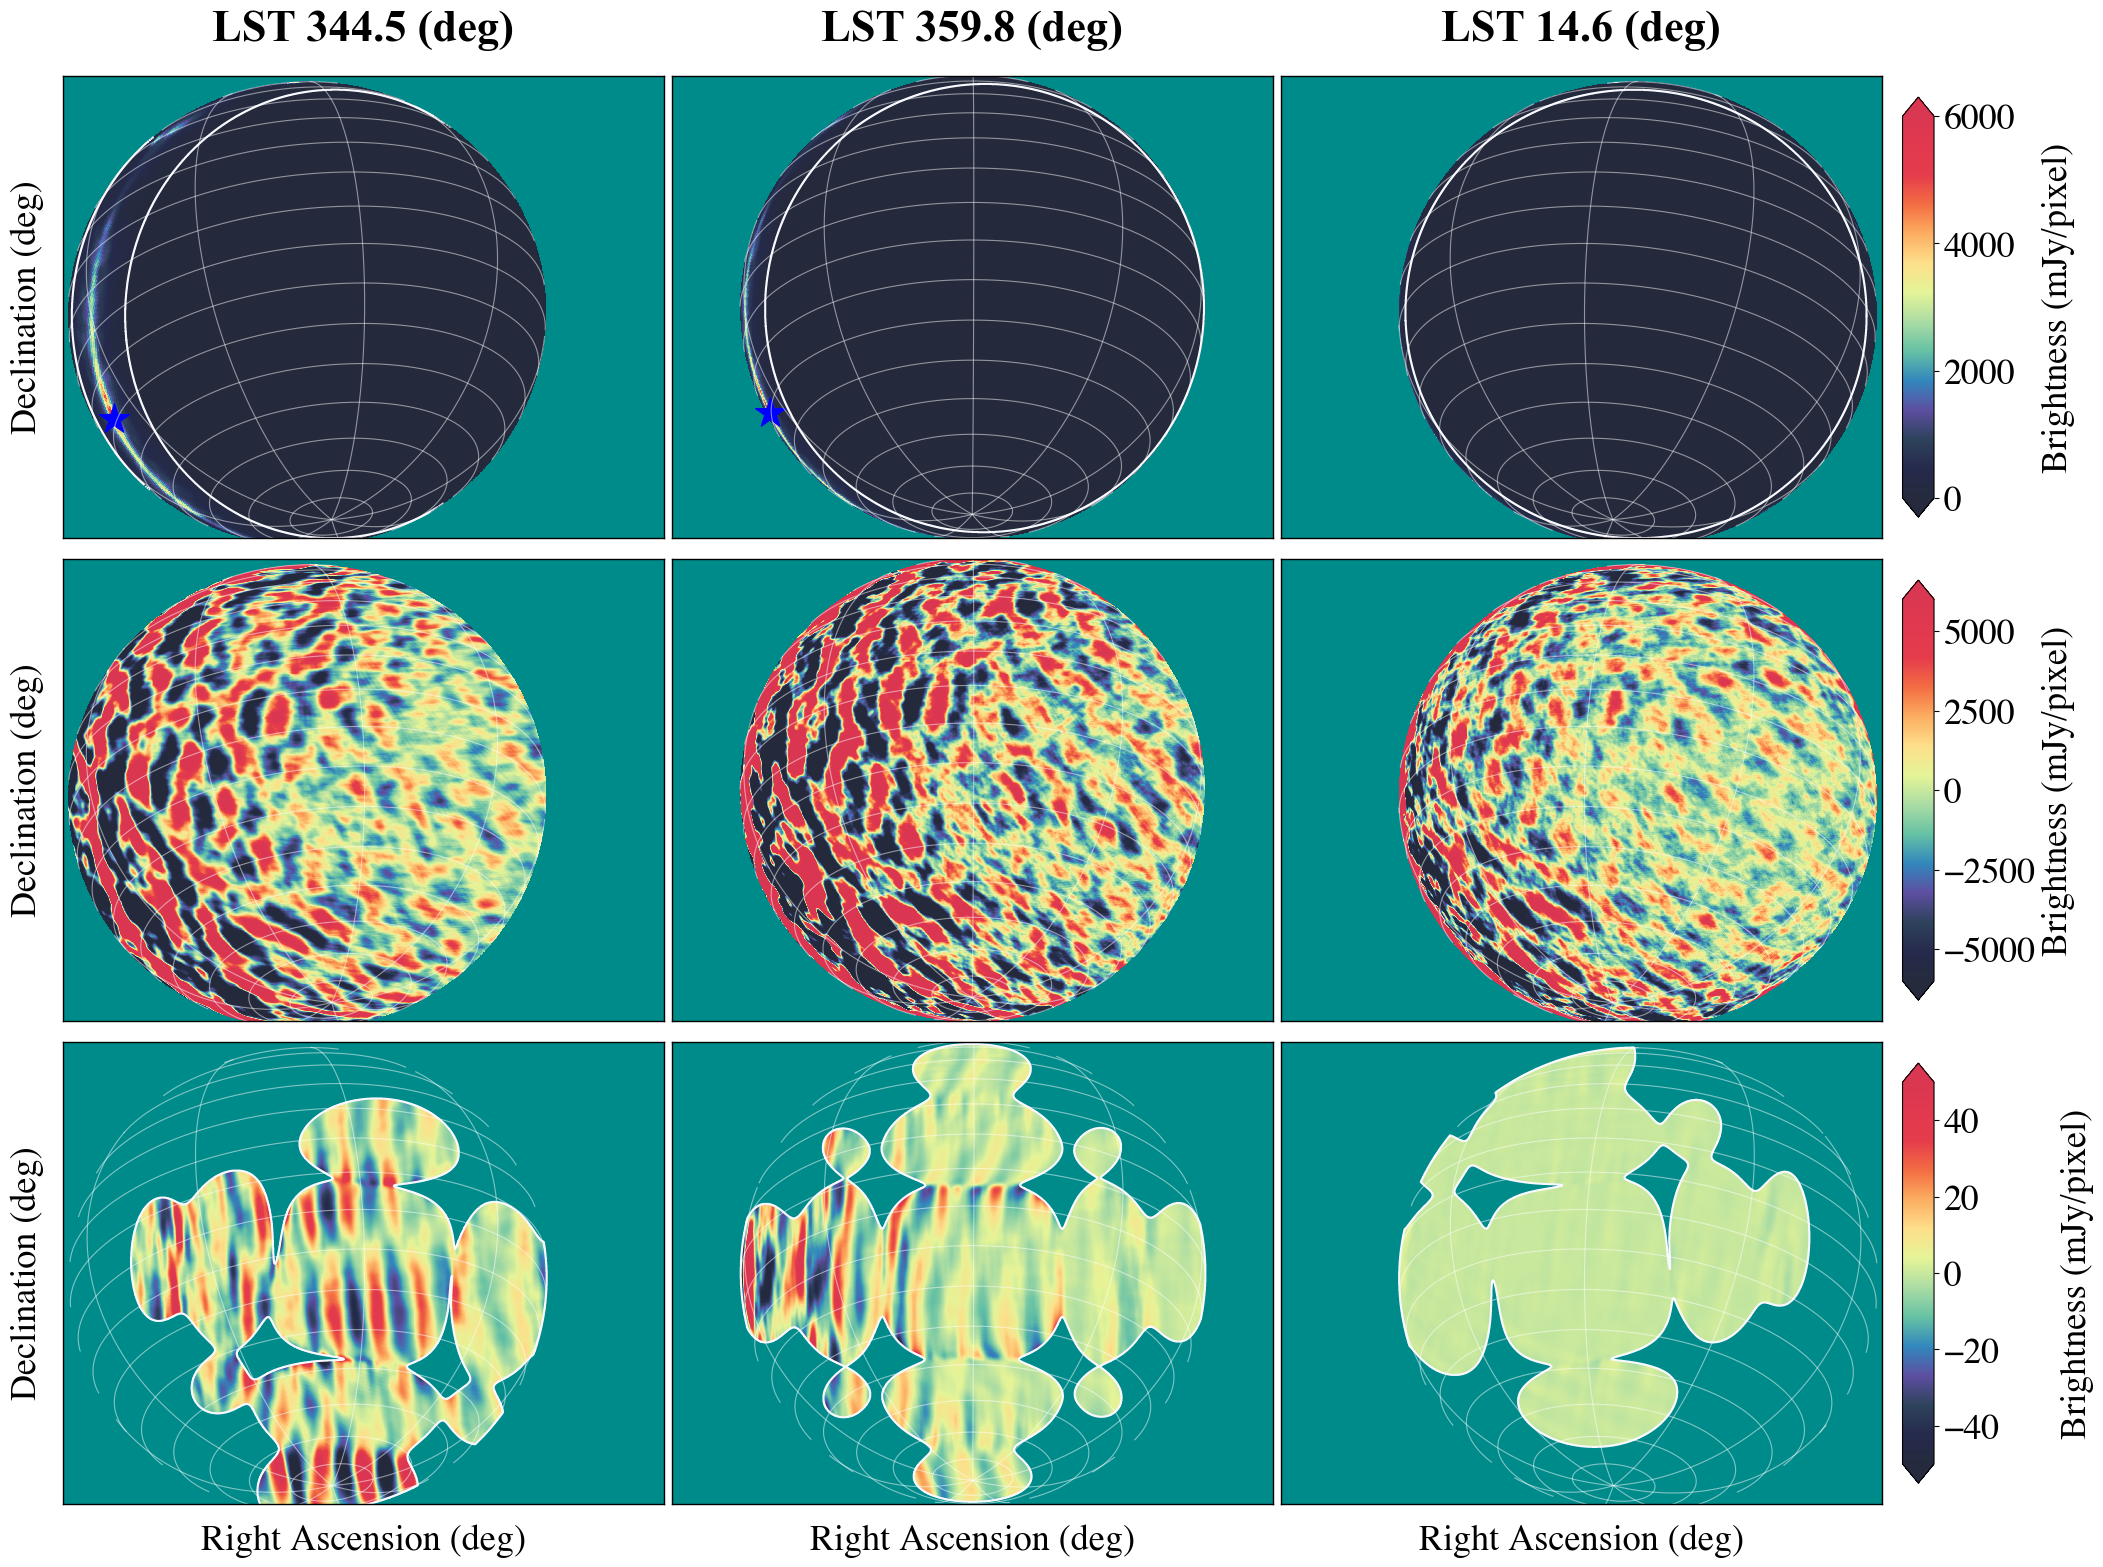

In [71]:
####### Publication FIGURE 1
## Panel plot of source catalog, nobeam aliasing, and MWA beam aliasing


def plot_defaults(f, data, cmap, vmin, vmax, xtext, ytext, fontsize=26):

    f.show_colorscale(cmap=cmap, stretch='linear',vmin=vmin,vmax=vmax)
    f.set_nan_color('darkcyan')
    f.show_contour(np.abs(data), levels=[0.00000001],colors='ghostwhite',linestyle=4)
    
    f.axis_labels.set_ytext(ytext)
    f.axis_labels.set_xtext(xtext)
    f.tick_labels.set_xformat('dd')
    f.tick_labels.set_font(size=18)
    f.axis_labels.set_font(size=fontsize)
    f.ticks.set_yspacing(10)
    f.ticks.set_xspacing(40)
    f.ticks.hide()
    f.tick_labels.hide()
    f.add_grid()
    
    return

def read_in_panel(files):
    
    ## Set file names to expected input order
    fitsfile_nobeam = files[0]
    fitsfile_yy = files[1]
    fitsfile_xx = files[2]
    ##
    
    ## Generate a reprojection for the catalog given a sample fitsfile from above
    fitsfile_catalog = reproject_galaxy(files[3], fitsfile_nobeam)
    _info = get_fitsinfo(fitsfile_catalog)
    hdr_catalog = _info['hdr']
    data_catalog = _info['data']/1000
    ##
    
    ## Read in data/hdr from each file
    fitsfile_nobeam = str_to_pixel(fitsfile_nobeam)
    _info = get_fitsinfo(fitsfile_nobeam)
    hdr_nobeam = _info['hdr']
    data_nobeam = _info['data']/1000
    
    _info = get_fitsinfo(fitsfile_yy)
    data_yy_pre = _info['data']
    fitsfile_yy = str_to_pixel(fitsfile_yy)
    _info = get_fitsinfo(fitsfile_yy)
    hdr_yy = _info['hdr']
    data_yy = _info['data']
    
    _info = get_fitsinfo(fitsfile_xx)
    data_xx_pre = _info['data']
    fitsfile_xx = str_to_pixel(fitsfile_xx)
    _info = get_fitsinfo(fitsfile_xx)
    hdr_xx = _info['hdr']
    data_xx = _info['data']
    ##
    
    return fitsfile_catalog, hdr_catalog, data_catalog, fitsfile_nobeam, hdr_nobeam, data_nobeam, fitsfile_yy, hdr_yy, data_yy, data_yy_pre, fitsfile_xx, hdr_xx, data_xx, data_xx_pre
    
def plot_aliasing(files, cmap=cb_spec, vmin=None, vmax=None, imsz=None, width=None, \
                             savefig=False, savepdf=False, fontsize=None, figname=''):
    
    fitsfile_catalog, hdr_catalog, data_catalog, fitsfile_nobeam, hdr_nobeam, data_nobeam, \
        fitsfile_yy, hdr_yy, data_yy, data_yy_pre, fitsfile_xx, hdr_xx, data_xx, data_xx_pre = read_in_panel(files[0:4])
    center_x = hdr_nobeam['CRVAL1']
    center_y = hdr_nobeam['CRVAL2']
    
    ## Plotting parameters for colors and plot locations
    fig = plt.figure(figsize=(21,21))
    xmin1=.03
    xmin2=.32
    xmin3=.61
    ymin1=.7
    ymin2=.47
    ymin3=.24
    xstretch=1.3
    cube=0.22
    title_pad=26 #in points
    
    #[left, bottom, width, height]
    subplot_loc_11 = [xmin1,ymin1,cube*xstretch,cube]
    subplot_loc_12 = [xmin2,ymin1,cube*xstretch,cube]
    subplot_loc_13 = [xmin3,ymin1,cube*xstretch,cube]
    subplot_loc_21 = [xmin1,ymin2,cube*xstretch,cube]
    subplot_loc_22 = [xmin2,ymin2,cube*xstretch,cube]
    subplot_loc_23 = [xmin3,ymin2,cube*xstretch,cube]
    subplot_loc_31 = [xmin1,ymin3,cube*xstretch,cube]
    subplot_loc_32 = [xmin2,ymin3,cube*xstretch,cube]
    subplot_loc_33 = [xmin3,ymin3,cube*xstretch,cube]
    ##
    
    
    ##### First column
    
    ## First plot in panel: Catalog at minus two pointing
    f1 = aplpy.FITSFigure(fitsfile_catalog, figure=fig, subplot=subplot_loc_11)
    f1.recenter(center_x, center_y, height=imsz, width=width*1.3)
    plot_defaults(f1, data_catalog, cmap, 0, 6000, ' ', 'Declination (deg)', fontsize=fontsize)
    f1.show_markers(266.416833333, -29.0078055556,marker="*",c="blue",s=500)
    f1.set_title('LST 344.5 (deg)',pad=title_pad,fontproperties=font_bold)
    ##
    
    ## Second plot in panel: Nobeam at minus two pointing
    f2 = aplpy.FITSFigure(fitsfile_nobeam, figure=fig, subplot=subplot_loc_21)
    f2.recenter(center_x, center_y, height=imsz, width=width)
    plot_defaults(f2, data_nobeam, cmap, -6000, 6000, ' ', 'Declination (deg)', fontsize=fontsize)
    ##
    
    ## Third plot in panel: YY at minus two pointing
    f3 = aplpy.FITSFigure(fitsfile_yy, figure=fig, subplot=subplot_loc_31)
    f3.recenter(center_x, center_y, height=width, width=imsz)
    plot_defaults(f3, data_yy, cmap, vmin, vmax, 'Right Ascension (deg)', 'Declination (deg)', fontsize=fontsize)
    f3.show_contour(np.abs(data_yy_pre), levels=[0.00000001],colors='ghostwhite',linestyle=4)
    ##

    ##### Second column
    
    fitsfile_catalog, hdr_catalog, data_catalog, fitsfile_nobeam, hdr_nobeam, data_nobeam, \
        fitsfile_yy, hdr_yy, data_yy, data_yy_pre, fitsfile_xx, hdr_xx, data_xx, data_xx_pre = read_in_panel(files[4:8])
    center_x = hdr_nobeam['CRVAL1']
    center_y = hdr_nobeam['CRVAL2']
    
    ## First plot in panel: Catalog at zenith pointing
    f1 = aplpy.FITSFigure(fitsfile_catalog, figure=fig, subplot=subplot_loc_12)
    f1.recenter(center_x, center_y, height=imsz, width=width*1.3)
    plot_defaults(f1, data_catalog, cmap, 0, 6000, ' ', ' ', fontsize=fontsize)
    f1.show_markers(266.416833333, -29.0078055556,marker="*",c="blue",s=500)
    f1.set_title('LST 359.8 (deg)',pad=title_pad,fontproperties=font_bold)
    ##
    
    ## Second plot in panel: Nobeam at zenith pointing
    f2 = aplpy.FITSFigure(fitsfile_nobeam, figure=fig, subplot=subplot_loc_22)
    f2.recenter(center_x, center_y, height=imsz, width=width)
    plot_defaults(f2, data_nobeam, cmap, -6000, 6000, ' ', ' ', fontsize=fontsize)
    ##
    
    ## Third plot in panel: YY at zenith pointing
    f3 = aplpy.FITSFigure(fitsfile_yy, figure=fig, subplot=subplot_loc_32)
    f3.recenter(center_x, center_y, height=width, width=imsz)
    plot_defaults(f3, data_yy, cmap, vmin, vmax, 'Right Ascension (deg)', ' ', fontsize=fontsize)
    f3.show_contour(np.abs(data_yy_pre), levels=[0.00000001],colors='ghostwhite',linestyle=4)
    ##
    
    ##### Third column
    
    files.append(files[11])
    fitsfile_catalog, hdr_catalog, data_catalog, fitsfile_nobeam, hdr_nobeam, data_nobeam, \
        fitsfile_yy, hdr_yy, data_yy, data_yy_pre, fitsfile_xx, hdr_xx, data_xx, data_xx_pre = read_in_panel(files[8:12])
    center_x = hdr_nobeam['CRVAL1']
    center_y = hdr_nobeam['CRVAL2']
    
    ## First plot in panel: Catalog at zenith pointing
    f1 = aplpy.FITSFigure(fitsfile_catalog, figure=fig, subplot=subplot_loc_13)
    f1.recenter(center_x, center_y, height=imsz, width=width*1.3)
    plot_defaults(f1, data_catalog, cmap, 0, 6000, ' ', ' ', fontsize=fontsize)
    f1.show_markers(266.416833333, -29.0078055556,marker="*",c="blue",s=500)
    f1.set_title('LST 14.6 (deg)',pad=title_pad,fontproperties=font_bold)
    ##
    
    ## Second plot in panel: Nobeam at zenith pointing
    f2 = aplpy.FITSFigure(fitsfile_nobeam, figure=fig, subplot=subplot_loc_23)
    f2.recenter(center_x, center_y, height=imsz, width=width)
    plot_defaults(f2, data_nobeam, cmap, -6000, 6000, ' ', ' ', fontsize=fontsize)
    ##
    
    ## Third plot in panel: YY at zenith pointing
    f3 = aplpy.FITSFigure(fitsfile_yy, figure=fig, subplot=subplot_loc_33)
    f3.recenter(center_x, center_y, height=width, width=imsz)
    plot_defaults(f3, data_yy, cmap, vmin, vmax, 'Right Ascension (deg)', ' ', fontsize=fontsize)
    f3.show_contour(np.abs(data_yy_pre), levels=[0.00000001],colors='ghostwhite',linestyle=4)
    ##
    
    
    ## Image color bar, initialised in first block on notebook
    #[left, bottom, width, height]
    cbar_ax = fig.add_axes([xmin3+cube*1.3+.01, ymin1+.01, 0.015, cube-.02])
    cbar = pl.colorbar(colorbar_scale_catalog, cax=cbar_ax,orientation="vertical",extend='both')
    cbar_ax.invert_xaxis()
    cbar.set_label(label='Brightness (mJy/pixel)',size=fontsize,fontproperties=font,labelpad=19)
    for tick in cbar_ax.xaxis.majorTicks:
        tick.label1.set_fontproperties(font)
    cbar_ax.tick_params(labelsize=fontsize)
    
    ##
    ## Image color bar, initialised in first block on notebook
    #[left, bottom, width, height]
    cbar_ax = fig.add_axes([xmin3+cube*1.3+.01, ymin2+.01, 0.015, cube-.02])
    cbar = pl.colorbar(colorbar_scale_nobeam, cax=cbar_ax,orientation="vertical",extend='both')
    cbar_ax.invert_xaxis()
    cbar.set_label(label='Brightness (mJy/pixel)',size=fontsize,fontproperties=font)
    for tick in cbar_ax.xaxis.majorTicks:
        tick.label1.set_fontproperties(font)
    cbar_ax.tick_params(labelsize=fontsize)
    ##
    ## Image color bar, initialised in first block on notebook
    #[left, bottom, width, height]
    cbar_ax = fig.add_axes([xmin3+cube*1.3+.01, ymin3+.01, 0.015, cube-.02])
    cbar = pl.colorbar(colorbar_scale_inst, cax=cbar_ax,orientation="vertical",extend='both') #,ticks=[-3,-2,-1,0,1,2,3])
    cbar_ax.invert_xaxis()
    cbar.set_label(label='Brightness (mJy/pixel)',size=fontsize,fontproperties=font,labelpad=43.5)
    for tick in cbar_ax.xaxis.majorTicks:
        tick.label1.set_fontproperties(font)
    cbar_ax.tick_params(labelsize=fontsize)
    ##
     
    if savefig:
        if savepdf:
            pp = PdfPages(figname + '.pdf')
            pp.savefig()
            pp.close()
        else:
            plt.savefig(figname, bbox_inches='tight', dpi=300)
            plt.close()
        
    else:
        plt.show()


dir_plt = '/Users/nicholebarry/MWA/data/fits_iamges/galaxy_only/3072/'
catalog_file = '/Users/nicholebarry/MWA/data/EDA2/EDA2_159MHz_I_wPriori_mono_2049.fits'

weighting='robust1'
#nobeam alaising and catalog at same projection, YY beam, XX beam, catalog
files = [dir_plt + 'nobeam/xx/1088281944_'+weighting+'_Model_XX.fits',\
         dir_plt + 'yy/1088281944_'+weighting+'_Model_YY.fits',\
         dir_plt + 'xx/1088281944_'+weighting+'_Model_XX.fits',\
         catalog_file,\
         dir_plt + 'nobeam/xx/1088285600_'+weighting+'_Model_XX.fits',\
         dir_plt + 'yy/1088285600_'+weighting+'_Model_YY.fits',\
         dir_plt + 'xx/1088285600_'+weighting+'_Model_XX.fits',\
         catalog_file,\
         dir_plt + 'nobeam/xx/1088289136_'+weighting+'_Model_XX.fits',\
         dir_plt + 'yy/1088289136_'+weighting+'_Model_YY.fits',\
         dir_plt + 'xx/1088289136_'+weighting+'_Model_XX.fits', catalog_file]
#1088281944,1088283768,1088285600,1088287432,1088289264

plot_aliasing(files, \
                vmax=50,vmin=-50,imsz=114, width=114, fontsize=26, savefig=True, savepdf=True, figname=dir_plt + 'aliasing_panel_robust')


In [ ]:
####### Calculation
## blob sizes conversion to Mpc scales during EoR

def scales_nobeam(fitsfile, cmap=colorbar_scale_nobeam, vmin=None, vmax=None, imsz=None, savefig=False, figname=''):
    
    ## Blob sizes conversion to Mpc scales during EoR
    aliased_size = np.array([3572.,9754.,8828.,6386.,14577.])/60./60.*3.14/180. #from radius in arcseconds to radian
    str_to_mpc = 8750.18 #str to Mpc at 182 MHz
    print(aliased_size**2.*str_to_mpc)
    
    
file = '/Users/nicholebarry/MWA/data/fits_iamges/galaxy_only/3072/nobeam/xx/1088285600_uniform_Model_XX.fits'

scales_nobeam(file, vmax=1000,vmin=-1000,imsz=114,savefig=False)

In [10]:
####### Calculation, completeness
## 
from matplotlib.backends.backend_pdf import PdfPages
from astropy.table import Table

def beam_fwhm(beamfiles):
    #Beam level
    beam_level = 0.5
    
    #Make Stokes I beam
    data_beam1, hdr1 = fits.getdata(beamfiles[0], header=True)
    data_beam2, hdr2 = fits.getdata(beamfiles[1], header=True)
    ra_beam, dec_beam = get_radec(beamfiles[1])
    ra_beam = ra_beam.reshape(-1)
    dec_beam = dec_beam.reshape(-1)
    data_stokes_beam = np.sqrt(data_beam1**2+data_beam2**2)
    data_stokes_beam_2D = data_stokes_beam / np.max(data_stokes_beam)
    data_stokes_beam = data_stokes_beam_2D.reshape(-1)
    
    ## Get ra/dec values within the fwhm of hte Stokes I beam
    within_fwhm_inds = np.argwhere(data_stokes_beam > beam_level)
    within_fwhm_inds = within_fwhm_inds.T[0]
    ra_beam_fwhm = ra_beam[within_fwhm_inds]
    
    #RA boundary messes with linear minmax, hence forcing the region
    within_fwhm_inds_min = np.argwhere(ra_beam_fwhm > 100).T[0]
    min_ra_beam = np.nanmin(ra_beam_fwhm[within_fwhm_inds_min])
    within_fwhm_inds_max = np.argwhere(ra_beam_fwhm < 50).T[0]
    max_ra_beam = np.nanmax(ra_beam_fwhm[within_fwhm_inds_max])
    min_dec_beam = np.nanmin(dec_beam[within_fwhm_inds])
    max_dec_beam = np.nanmax(dec_beam[within_fwhm_inds])
    
    print(min_ra_beam, max_ra_beam, min_dec_beam, max_dec_beam)
    
    return min_ra_beam, max_ra_beam, min_dec_beam, max_dec_beam, data_stokes_beam_2D

# Equation for Gaussian
def f(x, a, b, c):
    return a * np.exp(-(x - b)**2.0 / (2 * c**2))

def read_in_nomatch(table_files):
    
    nomatch_dec = []
    nomatch_ra = []
    nomatch_flux = []
    
    for table_file in table_files:
        table = Table.read(table_file)
    
        nomatch_dec.append(table['dec'])
        nomatch_ra.append(table['ra'])
        nomatch_flux.append(table['int_flux'])
            
    return nomatch_dec, nomatch_ra, nomatch_flux

def read_in_match(table_files):
    
    match_dec_1 = []
    match_ra_1 = []
    match_flux_1 = []
    match_flux_2 = []
    
    for table_file in table_files:
        table = Table.read(table_file)
    
        match_dec_1.append(table['dec_1'])
        match_ra_1.append(table['ra_1'])
        if "int_flux_1" in table.columns:
            match_flux_1.append(table['int_flux_1'])
            match_flux_2.append(table['int_flux_2'])
        else:
            match_flux_1.append(table['int_flux'])
            match_flux_2.append(table['P_FLX181'])
            
    return match_dec_1, match_ra_1, match_flux_1, match_flux_2

def find_remove_inds(ra,dec,min_dec_beam,max_dec_beam,min_ra_beam,max_ra_beam):
    ra = ra.reshape(-1)
    flip_inds_ra = np.argwhere((ra > 180)).T[0]
    ra[flip_inds_ra] = ra[flip_inds_ra] - 360
    
    center_ra = (max_ra_beam - (min_ra_beam-360)) / 2 + (min_ra_beam-360)
    center_dec = (max_dec_beam - min_dec_beam) / 2 + (min_dec_beam)
    max_ra = max_ra_beam - center_ra 
    ra = ra - center_ra
    dec = dec.reshape(-1) - center_dec
    dist_deg = np.sqrt(ra**2 + dec**2)
    remove_inds = np.argwhere((dist_deg > max_ra)).T[0]

    return remove_inds


def catalog_analysis(fitsfile, sample_fits, beamfiles, rmsfile, sizes, savefig=False, savepdf=False, figname=''):
 
    _info = get_fitsinfo(sample_fits)
    hdr_sample = _info['hdr']
    data_sample = _info['data']/1000
    blank_data = np.copy(data_sample)
    blank_data[:,:] = np.nan
    blank_fits = sample_fits.replace('.fits','.blank.fits')
    fits.writeto(blank_fits, blank_data, header=hdr_sample, overwrite=True)
    
    min_ra_beam, max_ra_beam, min_dec_beam, max_dec_beam, data_stokes_beam_2D = beam_fwhm(beamfiles)

    _info = get_fitsinfo(rmsfile)
    hdr_rms = _info['hdr']
    data_rms = _info['data']
    ra_rms, dec_rms = get_radec(rmsfile)

    remove_inds = find_remove_inds(ra_rms,dec_rms,min_dec_beam,max_dec_beam,min_ra_beam,max_ra_beam)
    data_rms = data_rms.reshape(-1)
    data_rms[remove_inds] = np.nan
    mean_data_rms = np.nanmedian(data_rms)*1000 #in mJy
    print(mean_data_rms)
    
    match_dec_eeg, match_ra_eeg, match_flux_eeg_1, match_flux_eeg_2 = read_in_match(
        [size_arr[0] for size_arr in fitsfile])  
    nomatch_dec_e, nomatch_ra_e, nomatch_flux_e = read_in_nomatch(
        [size_arr[1] for size_arr in fitsfile])
    nomatch_dec_eg, nomatch_ra_eg, nomatch_flux_eg = read_in_nomatch(
        [size_arr[2] for size_arr in fitsfile])
    
    # in1_ematcheg1_in2_lobes181_match...fits == matched sources (ra dec from in1) which are reliably matched to LoBES sources
    match_dec_lobes, match_ra_lobes, match_flux_lobes_1, match_flux_lobes_2 = read_in_match(
        [size_arr[3] for size_arr in fitsfile])  
    
    nomatch_dec_elobes, nomatch_ra_elobes, nomatch_flux_elobes = read_in_nomatch(
        [size_arr[4] for size_arr in fitsfile])
    nomatch_dec_eglobes, nomatch_ra_eglobes, nomatch_flux_eglobes = read_in_nomatch(
        [size_arr[5] for size_arr in fitsfile])
    match_dec_elobes, match_ra_elobes, match_flux_elobes_1, match_flux_elobes_2 = read_in_match(
        [size_arr[6] for size_arr in fitsfile])
    match_dec_eglobes, match_ra_eglobes, match_flux_eglobes_1, match_flux_eglobes_2 = read_in_match(
        [size_arr[7] for size_arr in fitsfile])
    
    #diff_in_flux_eg_e = [(match_flux_eeg_2[i] - match_flux_eeg_1[i])*1000 for i in range(len(match_flux_eeg_2))]#in mJy
    #diff_in_flux_eg = [((match_flux_eglobes_2[i] - match_flux_eglobes_1[i])/match_flux_eglobes_2[i])*100 for i in range(len(match_flux_elobes_1))]#in mJy
    #diff_in_flux_e = [((match_flux_elobes_2[i] - match_flux_elobes_1[i])/match_flux_elobes_2[i])*100 for i in range(len(match_flux_elobes_1))]#in mJy
    diff_in_flux_eg = [((match_flux_eglobes_2[i] - match_flux_eglobes_1[i])*1000) for i in range(len(match_flux_elobes_1))]#in mJy
    diff_in_flux_e = [((match_flux_elobes_2[i] - match_flux_elobes_1[i])*1000) for i in range(len(match_flux_elobes_1))]#in mJy
    
    for size_i in range(len(match_flux_eeg_2)):
        #remove_inds = find_remove_inds(match_ra_eeg[size_i],match_dec_eeg[size_i],min_dec_beam,max_dec_beam,
        #                               min_ra_beam,max_ra_beam)
        remove_inds = find_remove_inds(match_ra_eglobes[size_i],match_dec_eglobes[size_i],min_dec_beam,max_dec_beam,
                                       min_ra_beam,max_ra_beam)
        diff_in_flux_eg[size_i][remove_inds] = np.nan
        remove_inds = find_remove_inds(match_ra_elobes[size_i],match_dec_elobes[size_i],min_dec_beam,max_dec_beam,
                                       min_ra_beam,max_ra_beam)
        diff_in_flux_e[size_i][remove_inds] = np.nan
    
        remove_inds = find_remove_inds(nomatch_ra_e[size_i],nomatch_dec_e[size_i],min_dec_beam,max_dec_beam,
                                       min_ra_beam,max_ra_beam)
        nomatch_flux_e[size_i][remove_inds] = np.nan
    
        remove_inds = find_remove_inds(nomatch_ra_eg[size_i],nomatch_dec_eg[size_i],min_dec_beam,max_dec_beam,
                                       min_ra_beam,max_ra_beam)
        nomatch_flux_eg[size_i][remove_inds] = np.nan
        
        remove_inds = find_remove_inds(nomatch_ra_elobes[size_i],nomatch_dec_elobes[size_i],min_dec_beam,max_dec_beam,
                                       min_ra_beam,max_ra_beam)
        nomatch_flux_elobes[size_i][remove_inds] = np.nan
        
        nomatch_ra_elobes[size_i][remove_inds] = np.nan
        nomatch_dec_elobes[size_i][remove_inds] = np.nan
    
        remove_inds = find_remove_inds(nomatch_ra_eglobes[size_i],nomatch_dec_eglobes[size_i],min_dec_beam,max_dec_beam,
                                       min_ra_beam,max_ra_beam)
        nomatch_flux_eglobes[size_i][remove_inds] = np.nan
        
        remove_inds = find_remove_inds(match_ra_eglobes[size_i],match_dec_eglobes[size_i],min_dec_beam,max_dec_beam,
                                       min_ra_beam,max_ra_beam)
        match_flux_eglobes_1[size_i][remove_inds] = np.nan
        match_flux_eglobes_2[size_i][remove_inds] = np.nan
        
        match_ra_eglobes[size_i][remove_inds] = np.nan
        match_dec_eglobes[size_i][remove_inds] = np.nan
        
        remove_inds = find_remove_inds(match_ra_elobes[size_i],match_dec_elobes[size_i],min_dec_beam,max_dec_beam,
                                       min_ra_beam,max_ra_beam)
        match_flux_elobes_1[size_i][remove_inds] = np.nan
        match_flux_elobes_2[size_i][remove_inds] = np.nan
        
        match_ra_elobes[size_i][remove_inds] = np.nan
        match_dec_elobes[size_i][remove_inds] = np.nan
        
        make_plots(diff_in_flux_eg[size_i], diff_in_flux_e[size_i], nomatch_flux_e[size_i], nomatch_flux_eg[size_i], 
                   match_flux_elobes_1[size_i], match_flux_eglobes_1[size_i], 
                   match_flux_elobes_2[size_i]*1000, match_flux_eglobes_2[size_i]*1000,
                   nomatch_flux_elobes[size_i], nomatch_flux_eglobes[size_i], mean_data_rms,
                   blank_fits, hdr_sample, data_stokes_beam_2D, match_ra_elobes[size_i], match_dec_elobes[size_i], nomatch_ra_elobes[size_i], nomatch_dec_elobes[size_i],
                   figname+str(sizes[size_i]),savefig=savefig, savepdf=savepdf)
    
    
def make_plots(diff_in_flux_eg, diff_in_flux_e, nomatch_flux_e, nomatch_flux_eg, match_flux_elobes, match_flux_eglobes,
               match_flux_elobes_2, match_flux_eglobes_2,
               nomatch_flux_elobes, nomatch_flux_eglobes, mean_data_rms,
               blank_fits, hdr_sample, data_stokes_beam_2D, match_ra_elobes, match_dec_elobes, nomatch_ra_elobes, nomatch_dec_elobes,
               figname, savefig=False, savepdf=False):
    ## diff_in_flux_eg, diff_in_flux_e: Difference in flux from measurement value from given catalog compared to input
    ## nomatch_flux_e, nomatch_flux_eg: Sources which are not true matches to the input
    ## match_flux_elobes, match_flux_eglobes, match_flux_eglobes_2: Sources which are matched to input, 2 indicates flux from lobes (true flux)
    
    fig = plt.figure(figsize=(21,21))
    plt.rcParams.update({'axes.facecolor':'aliceblue'})
    #[left, bottom, width, height]
    subplot_loc_1 = [.1,.5,.35,.35]
    subplot_loc_2 = [.1,.1,.35,.35]
    
    fontsize=26
    hist_color = ['g','i','j']
    bins = np.arange(0, 360 + 1, 5)
    hist_eg, bin_edges = np.histogram(diff_in_flux_eg, bins=bins)
    hist_e, bin_edges = np.histogram(diff_in_flux_e, bins=bins)

    width = (bin_edges[1]- bin_edges[0])
    
    std_e = np.zeros(len(bins))
    std_eg = np.zeros(len(bins))
    
    for i in range(len(bins)):
        inds_fluxbin = np.argwhere((match_flux_elobes_2 > bin_edges[i]) & (match_flux_elobes_2 < (bin_edges[i]+width)))
        if inds_fluxbin.size > 9:
            std_e[i] = np.nanstd(diff_in_flux_e[inds_fluxbin])
        else:
            std_e[i] = 0
        
        inds_fluxbin = np.argwhere((match_flux_eglobes_2 > bin_edges[i]) & (match_flux_eglobes_2 < (bin_edges[i]+width)))
        if inds_fluxbin.size > 9:
            std_eg[i] = np.nanstd(diff_in_flux_eg[inds_fluxbin])
        else:
            std_eg[i] = 0
    
    #x = bin_edges[1:]+width/2
    #popt, pcov = optimize.curve_fit(f, x, hist)
    #x_fit = np.linspace(x[0], x[-1], 10000)
    #y_fit = f(x_fit, *popt)

    #print(std_eg - std_e)
    
    plt.axes(subplot_loc_1)
    plt.bar(bin_edges, std_eg - std_e, width=width, color=hist_color[0], alpha = 0.75, edgecolor=hist_color[0], linewidth=3)
    #plt.bar(bin_edges, std_e, width=width, color=hist_color[1], alpha = 0.75, edgecolor=hist_color[1], linewidth=3)
    #plt.bar(bin_edges[1:], hist_e, width=width, color=hist_color[1], alpha = 0.75, edgecolor=hist_color[0], linewidth=3)
    #plt.plot([mean_data_rms,mean_data_rms], [0,10*np.max(hist_eg)], linestyle='dashed', linewidth=3, color=hist_color[1])
    #plt.plot([-mean_data_rms,-mean_data_rms], [0,10*np.max(hist_eg)], linestyle='dashed', linewidth=3, color=hist_color[1])
    #plt.plot(x_axis, norm.pdf(x_axis, mu_flux_change, sigma_flux_change)*max((match_flux_in2 - match_flux_in1) / match_flux_in1))
    #plt.plot(x_fit, y_fit, lw=4, color="r")
    #plt.xlim([0,50])
    #plt.xlabel('$\Delta$Brightness [mJy]')
    plt.xlabel('Integrated flux [mJy]')
    #plt.ylabel('Number of Matched Sources')
    plt.ylabel('Standard deviation in detected integrated flux [mJy]')
    #plt.yscale('log')
    #plt.ylim([.9,3000])
    #plt.xlim([-200,200])
    #plt.xticks([-1,0,1])

    # Legend
    f1_label = ['Extragalatic and Galactic\nsubtraction catalog', 'Extragalatic\nsubtraction catalog']
    linewidth = [8,8]
    alpha = [.75,.75]
    linestyle = ['solid','solid']
    patches = [ plt.plot([],[], mec=None, color=hist_color[type_i], linewidth=linewidth[type_i], linestyle=linestyle[type_i],
            alpha=alpha[type_i], label="{:s}".format(f1_label[type_i]) )[0]  for type_i in range(len(f1_label)) ]
    legend2 = plt.legend(handles=patches, bbox_to_anchor=(0.785, 0.86),loc='center', ncol=1, frameon=False,
                    fontsize=fontsize-2,title_fontsize=fontsize,handlelength=1)
    legend2._legend_box.align='left'
    legend2.get_title().set_multialignment('center')
    a2=plt.gca()
    a2.add_artist(legend2)
    
    bins = np.arange(-1, 500 + 1, 5)
    hist_color = ['g','i','j']
    
    hist_e, bin_edges = np.histogram(nomatch_flux_elobes*1000, bins=bins)
    hist_eg, bin_edges = np.histogram(nomatch_flux_eglobes*1000, bins=bins)
    hist_e_match, bin_edges = np.histogram(match_flux_elobes*1000, bins=bins)
    hist_eg_match, bin_edges = np.histogram(match_flux_eglobes*1000, bins=bins)

    width = (bin_edges[1]- bin_edges[0])
    plt.axes(subplot_loc_2)
    plt.bar(bin_edges[1:], (hist_eg_match - hist_eg)/hist_eg_match, width=width, color=hist_color[0], alpha = 0.75, edgecolor=hist_color[0], linewidth=3)
    plt.bar(bin_edges[1:], (hist_e_match - hist_e)/hist_e_match, width=width, color=hist_color[1], alpha = 0.75, edgecolor=hist_color[1], linewidth=3)
    plt.plot([mean_data_rms,mean_data_rms], [0,10*np.max(hist_eg)], linestyle='dashed', linewidth=3, color=hist_color[2])
    plt.xlabel('Brightness [mJy]')
    plt.ylabel('Rate of Real Detections')
    plt.xlim([0,100])
    plt.ylim([-1,1])
    plt.xticks([0,50])
    plt.yticks([0.85,1.1])
    
    # Legend
    f1_label = ['Extragalatic and Galactic\nsubtraction catalog', 'Extragalatic\nsubtraction catalog', 'Integrated data\nimage mean RMS']
    linewidth = [8,8,4]
    alpha = [.75,.75, 1]
    linestyle = ['solid','solid','dashed']
    patches = [ plt.plot([],[], mec=None, color=hist_color[type_i], linewidth=linewidth[type_i], linestyle=linestyle[type_i],
            alpha=alpha[type_i], label="{:s}".format(f1_label[type_i]) )[0]  for type_i in range(len(f1_label)) ]
    legend1 = plt.legend(handles=patches, bbox_to_anchor=(0.7, 0.82),loc='center', ncol=1, frameon=False,
                    fontsize=fontsize-2,title_fontsize=fontsize,handlelength=1)
    legend1._legend_box.align='left'
    legend1.get_title().set_multialignment('center')
    a2=plt.gca()
    a2.add_artist(legend1)
    
    
    
    
    
    ## First plot in panel: Catalog at minus two pointing
    f1 = aplpy.FITSFigure(blank_fits, figure=fig)
    f1.recenter(hdr_sample['CRVAL1'], hdr_sample['CRVAL2'], height=25, width=25)
    f1.show_colorscale(cmap=cb_spec, stretch='linear',vmin=-100,vmax=100)
    f1.set_nan_color('darkcyan')
    #f1.show_contour(np.abs(data_sample), levels=[0.00000001],colors='ghostwhite',linestyle=4)
    f1.show_contour(np.abs(data_stokes_beam_2D), levels=[0.5],colors='ghostwhite',linestyle=4)
    f1.axis_labels.set_ytext('Declination (deg)')
    f1.axis_labels.set_xtext('Right Ascension (deg)')
    f1.tick_labels.set_xformat('dd')
    f1.tick_labels.set_font(size=18)
    f1.axis_labels.set_font(size=18)
    f1.ticks.set_yspacing(10)
    f1.ticks.set_xspacing(40)
    f1.ticks.hide()
    f1.tick_labels.hide()
    f1.add_grid()
    #f1.set_title('LST xx (deg)',pad=title_pad,fontproperties=font_bold)
    
    norm = matplotlib.colors.Normalize(vmin=0.0, vmax=100.0)
    rgba = cb_spec(norm(match_flux_elobes*1000))
    f1.show_markers(match_ra_elobes, match_dec_elobes,marker="o",c=rgba,s=100*norm(np.abs(match_flux_elobes*1000)))
    
    abs_norm = matplotlib.colors.Normalize(vmin=0.0, vmax=100.0)
    rgba = cb_spec(abs_norm(nomatch_flux_elobes*1000))
    f1.show_markers(nomatch_ra_elobes, nomatch_dec_elobes,marker="s",c=rgba,s=100*abs_norm(nomatch_flux_elobes*1000))
    ##
    
    if savefig:
        if savepdf:
            pp = PdfPages(figname + '.pdf')
            pp.savefig()
            pp.close()
        else:
            plt.savefig(figname, bbox_inches='tight', dpi=300)
            plt.close()
        
    else:
        plt.show()

        
dir_plt = '/Users/nicholebarry/MWA/data/fits_iamges/source_matching/updated20/'
sizes = ['4096','6144','8192']

# in1_e_in2_eg_match...fits == matched sources between the extragalactic and extragalactic + Galactic models
# in1_e_in2_eg_1not2...fits == sources in the extragalactic model which aren't in extragalactic + Galactic model
# in1_e_in2_eg_2not1...fits == sources in the extragalactic + Galactic model which aren't in extragalactic model
# in1_ematcheg1_in2_lobes181_match...fits == matched sources (ra dec from in1) which are reliably matched to LoBES sources
# in1_unmatchedine_in2_lobes181_1not2...fits == sources in extragalactic and not extragalactic + Galactic which are not reliably matched to LoBES sources
# in1_unmatchedineg_in2_lobes181_1not2...fits == sources in extragalactic + Galactic and not extragalactic which are not reliably matched to LoBES sources
files = [[dir_plt + 'in1_e_in2_eg_match_sim_zenith_'+size+'_briggs.fits', \
         dir_plt + 'in1_e_in2_eg_1not2_sim_zenith_'+size+'_briggs.fits', \
         dir_plt + 'in1_e_in2_eg_2not1_sim_zenith_'+size+'_briggs.fits', \
         dir_plt + 'in1_ematcheg1_in2_lobes181_match_sim_zenith_'+size+'_briggs.fits', \
         #dir_plt + 'in1_unmatchedine_in2_lobes181_1not2_sim_zenith_'+size+'_briggs.fits', \
         #dir_plt + 'in1_unmatchedineg_in2_lobes181_1not2_sim_zenith_'+size+'_briggs.fits', \
         dir_plt + 'in1_e_in2_lobes181g_1not2_sim_zenith_'+size+'_briggs.fits', \
         dir_plt + 'in1_eg_in2_lobes181g_1not2_sim_zenith_'+size+'_briggs.fits', \
         dir_plt + 'in1_matchine_in2_lobes181_match_sim_zenith_'+size+'_briggs.fits', \
         dir_plt + 'in1_matchineg_in2_lobes181_match_sim_zenith_'+size+'_briggs.fits'] for size in sizes] 

sample_fits = '/Users/nicholebarry/MWA/data/fits_iamges/source_matching/1088285600_uniform_Model_I.fits'
beamfiles=['/Users/nicholebarry/MWA/data/fits_iamges/source_matching/1088285600_Beam_XX.fits', \
           '/Users/nicholebarry/MWA/data/fits_iamges/source_matching/1088285600_Beam_YY.fits']
rmsfile=dir_plt+'/eg_data_zenith_8192__rms.fits'

catalog_analysis(files,sample_fits,beamfiles,rmsfile,sizes,savefig=True,savepdf=False,figname=dir_plt + 'source_modelling_')

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


348.7804844836786 10.653555484931758 -36.397843804565014 -16.94226015697454


5.288565997034311


/var/folders/bq/wmsr1m_d2c94qwkmz9xyr3g80000gn/T/ipykernel_73557/3751520968.py:283: RuntimeWarning: divide by zero encountered in divide
  plt.bar(bin_edges[1:], (hist_eg_match - hist_eg)/hist_eg_match, width=width, color=hist_color[0], alpha = 0.75, edgecolor=hist_color[0], linewidth=3)
/var/folders/bq/wmsr1m_d2c94qwkmz9xyr3g80000gn/T/ipykernel_73557/3751520968.py:283: RuntimeWarning: invalid value encountered in divide
  plt.bar(bin_edges[1:], (hist_eg_match - hist_eg)/hist_eg_match, width=width, color=hist_color[0], alpha = 0.75, edgecolor=hist_color[0], linewidth=3)
/var/folders/bq/wmsr1m_d2c94qwkmz9xyr3g80000gn/T/ipykernel_73557/3751520968.py:284: RuntimeWarning: divide by zero encountered in divide
  plt.bar(bin_edges[1:], (hist_e_match - hist_e)/hist_e_match, width=width, color=hist_color[1], alpha = 0.75, edgecolor=hist_color[1], linewidth=3)
/var/folders/bq/wmsr1m_d2c94qwkmz9xyr3g80000gn/T/ipykernel_73557/3751520968.py:284: RuntimeWarning: invalid value encountered in divide
 

In [124]:
# PUBLICATION Figure 3
# Power spectra 1D portion

## Brad Greig's fiducial theory and confidence limits for redshift 7
# GalaxyParam_LF+NF+Tau

def theory_fiducial(hubble_param=0.71):
    
    
    #Fourier mode (k [Mpc^-1]), 68th, 95th and 99th percentiles on the power spectrum in units of mK^2
    brad_k = np.array([0.02094395,0.03183814,0.0477084,0.06481693,0.0846983,0.1122589,0.1512655,0.2037167,0.2749778,0.3717481,0.5018322,0.6776517,0.9149306,1.235268,1.6676,2.207298,2.79783])
    brad_68 = np.array([2.06836030818,9.33650238046,13.5354885655,27.9094808815,31.8379169811,35.6549002097,
               37.7766299375,34.7228577191,22.5256589937,19.1373452916,19.0715957566,18.8232315706,18.1639861695,
               18.6493671092,21.4087292929,28.7580668946,40.4441293602])
    brad_95 = np.array([3.00633765723,12.8642551767,18.6682120582,38.322192403,43.5651253669,49.1075159329,
               51.9213041607,48.790639303,31.3894142399,26.2910138229,26.8292876974,26.5396841581,26.0301170622,
               27.1653881665,31.5002616162,42.7424864461,60.1632270707])
    brad_99 = np.array([3.277767,13.62931,19.91,40.66932,46.2304,52.1699,55.14123,52.86583,34.2097,28.67557,29.69817,29.57222,
               29.46968,30.93632,35.9361,48.86067,68.80418])

    #k (Mpc^-1) and fiducial
    brad_k_fid = np.array([2.094395e-02,3.183814e-02,4.770840e-02,6.481693e-02,8.469830e-02,1.122589e-01, 1.512655e-01,2.037167e-01,2.749778e-01,3.717481e-01,
                5.018322e-01,6.776517e-01,9.149306e-01,1.235268e+00,1.667600e+00,2.207298e+00,2.797836e+00])
    brad_fiducial = np.array([3.148450e-01,1.371862e+00,2.112182e+00,4.716543e+00,6.822401e+00,1.036046e+01,1.477729e+01,9.501991e+00,8.793401e+00,7.287165e+00,
                    6.430653e+00,5.709567e+00,5.390083e+00,5.408442e+00,6.280324e+00,8.959497e+00,1.353618e+01])

    brad_k_fid = brad_k_fid/hubble_param
    brad_k = brad_k/hubble_param
    
    return brad_k_fid, brad_fiducial, brad_95

## Load IDL text files 
# Expected header: k bin max (h Mpc^-1), power (mK^2 h^-3 Mpc^3), sigma (mK^2 h^-3 Mpc^3), 
# expected noise (mK^2 h^-3 Mpc^3), observed noise (mK^2 h^-3 Mpc^3), sim noise power (mK^2 h^-3 Mpc^3),
# sim noise diff (mK^2 h^-3 Mpc^3)

def load_IDL_data(file_name,hubble_param=0.71):
    
    
    # Load data and select
    data = np.loadtxt(file_name,skiprows=1)
    k_edges = data[:,0] # Lower and upper edge of bin, (h Mpc^-1)
    power = data[1:,1] # Observed power in each bin, (mK^2 h^-3 Mpc^3), first entry is a placeholder
    sigma = data[1:,2]
     
    # Construct k center from the edges
    n_k_edges = len(k_edges)
    k_center = (k_edges[1:n_k_edges]+k_edges[0:n_k_edges-1])/2.
        
    # Construct power in mK^2 units
    delta = (power)*(k_center**3.)/(2*np.pi**2)
    dsigma=sigma*(k_center**3.)/(2.*np.pi**2)

    # Construct k in h Mpc^-1. The cake is a lie.
    #k_edges=k_edges/hubble_param
        
    # Create histogram style data set by repeating the data 
    # Duplicate the bin edges so each bin has left and right data point
    # Duplicate the power so each bin edge has a measurement
    k_edges_hist  = np.repeat(k_edges,2)[1:-1]
    delta_hist  = np.repeat(delta,2)
    dsigma_hist  = np.repeat(dsigma,2)

    return k_edges_hist, delta_hist, dsigma_hist

#Plot just model or measured power data -- not for limits

def plot_hist(idl_files,max_k=1.9,min_k=.14,min_d=.1,max_d=10**6,mode='wide',flagcoarse=False,
             savefig=False, figname='', full_legend=False):
    
    fig = plt.figure(figsize=(21,21))
    #fig, ax = plt.subplots()
    fontsize=22
    linewidth=2
    plt.rcParams.update({'axes.facecolor':'aliceblue'})
    plt.rcParams["mathtext.fontset"] = "stix"
    
    # Read-in and calculate limits
    brad_k_fid, brad_fiducial, brad_95 = theory_fiducial()
    k_edges_hist_flag, delta_hist_flag, dsigma_hist_flag = load_IDL_data(idl_files[0])
    k_edges_hist_yy, delta_hist_yy, dsigma_hist_yy = load_IDL_data(idl_files[1])
    k_edges_hist_cal, delta_hist_cal, dsigma_hist_cal = load_IDL_data(idl_files[2])
    
    # Set 0's to nans for plotting purposes
    dsigma_hist_flag[delta_hist_flag==0] = np.nan
    dsigma_hist_yy[delta_hist_yy==0] = np.nan
    dsigma_hist_cal[delta_hist_cal==0] = np.nan
    delta_hist_flag[delta_hist_flag==0] = np.nan
    delta_hist_yy[delta_hist_yy==0] = np.nan
    delta_hist_cal[delta_hist_cal==0] = np.nan

    # Plotting defaults
    #[left, bottom, width, height]
    subplot_loc_left = [.1,.6,.4,.25]
    subplot_loc_right = [.5,.6,.4,.25]
    subplot_loc_top = [.1,.5,.4,.25]
    subplot_loc_bottom = [.1,.25,.4,.25]
    #hist_color = ['black','orangered','orangered','peru','peru']
    #hist_color = ['black','darkcyan','darkcyan','peru','peru']
    hist_color=['e','e','i','e']
    legend1_loc = (0.42, 0.9)
    legend2_loc = (0.41, 0.768)

    
    if mode == 'xx':
        subplot_loc = [subplot_loc_left] 
        axeslabel = ['$\Delta^2$ (mK$^2$)','$k$ (h Mpc$^{-1}$)']
        yticklabel = [[10**2,10**4]]
        xticklabel = [[10**0]]
        
    if mode == 'yy':
        k_edges_hist_xx = k_edges_hist_yy
        delta_hist_xx = delta_hist_yy
        dsigma_hist_xx = dsigma_hist_yy
        
        subplot_loc = [subplot_loc_left] 
        axeslabel = ['$\Delta^2$ (mK$^2$)','k ($\it{h}$ Mpc$^{-1}$)']
        yticklabel = [[10**2,10**4]]
        xticklabel = [[10**0]]
        
    if mode == 'wide':
        subplot_loc = [subplot_loc_left,subplot_loc_right] 
        axeslabel = ['$\Delta^2$ (mK$^2$)','$k$ (h Mpc$^{-1}$)','','$k$ (h Mpc$^{-1}$)']
        yticklabel = [[10**2,10**4,10**6,10**8],[]]
        xticklabel = [[10**0],[10**0]]

    if mode == 'tall':
        subplot_loc = [subplot_loc_top,subplot_loc_bottom] 
        axeslabel = ['$\Delta^2$ (mK$^2$)','k (h Mpc$^{-1}$)','$\Delta^2$ (mK$^2$)','']
        yticklabel = [[10**2,10**4,10**6,10**8],[10**2,10**4,10**6,10**8]]
        xticklabel = [[],[10**0]]
    
    
    #Plot measured power, limits, theory
    plt.axes(subplot_loc[0])
    plt.plot(brad_k_fid, brad_fiducial, ls='solid', color=hist_color[2],linewidth=linewidth)
    plt.plot(k_edges_hist_flag, delta_hist_flag, ls='dotted', color=hist_color[0],linewidth=linewidth)
    plt.plot(k_edges_hist_flag, delta_hist_yy, ls='solid', color=hist_color[1],linewidth=linewidth)
    plt.plot(k_edges_hist_flag[:-2], delta_hist_cal[:-2], ls='dashed', color=hist_color[3],linewidth=linewidth)
    
    #plt.plot(brad_k_fid, brad_95, ls='dashed', color=hist_color[2],linewidth=linewidth)
    plt.fill_between(brad_k_fid, min_d, brad_95, color=hist_color[2],alpha=0.35)
    currentAxis = plt.gca()
    
    #Plot defaults
    plt.loglog()
    plt.tick_params(direction='in', color='k', which='both', top=True, bottom=True, 
                    left=True, right=True, labelsize=fontsize, width=2, length=6)
    plt.xlim(min_k,max_k)
    plt.ylim(min_d,max_d)
    plt.yticks(yticklabel[0])
    plt.xticks(xticklabel[0])
    plt.ylabel(axeslabel[0], fontsize=fontsize)
    plt.xlabel(axeslabel[1], fontsize=fontsize)
             
    #Tick Formatting
    a=plt.gca()
    a.yaxis.set_minor_locator(ticker.LogLocator(base=10, numticks=20))
    a.yaxis.set_minor_formatter(ticker.NullFormatter())
    
    # Legend
    #f1_label = ['Simulated MWA Galactic plane\n(typical flagging)','Simulated MWA Galactic plane','fiducial theory']
    #linestyle = ['solid','dashed','solid']
    f1_label = ['fiducial theory','Simulated MWA Galactic plane']
    linestyle = ['solid','solid']
    hist_color=['i','e']
    patches = [ plt.plot([],[], mec=None, color=hist_color[type_i], linewidth=linewidth, linestyle=linestyle[type_i],
            label="{:s}".format(f1_label[type_i]) )[0]  for type_i in range(len(f1_label)) ]
    legend1 = plt.legend(handles=patches, bbox_to_anchor=legend1_loc,loc='center', ncol=1, frameon=False,
                    fontsize=fontsize-4,title_fontsize=fontsize,handlelength=1.8)
    legend1._legend_box.align='left'
    legend1.get_title().set_multialignment('center')
    a.add_artist(legend1)
    
    # Legend, indented
    #f1_label = ['Simulated MWA Galactic plane\n(typical flagging)','Simulated MWA Galactic plane','fiducial theory']
    #linestyle = ['solid','dashed','solid']
    f1_label = ['(with calibration errors)','(with typical flagging)']
    linestyle = ['dashed','dotted']
    hist_color=['e','e']
    patches = [ plt.plot([],[], mec=None, color=hist_color[type_i], linewidth=linewidth, linestyle=linestyle[type_i],
            label="{:s}".format(f1_label[type_i]) )[0]  for type_i in range(len(f1_label)) ]
    legend1 = plt.legend(handles=patches, bbox_to_anchor=legend2_loc,loc='center', ncol=1, frameon=False,
                    fontsize=fontsize-4,title_fontsize=fontsize,handlelength=1.4)
    legend1._legend_box.align='left'
    legend1.get_title().set_multialignment('center')
    a.add_artist(legend1)
    
    fig.text(0, .3, 'k$_\perp$ ($\it{h}$ Mpc$^{-1}$)',rotation='horizontal',
         multialignment='center',fontsize=fontsize)
    fig.text(.1, .3, 'k$_{||}$ ($\it{h}$ Mpc$^{-1}$)',rotation='vertical',
         multialignment='center',fontsize=fontsize)
    fig.text(.2, .3, '(mK$^2$ $\it{h}^{-3}$ Mpc$^{3}$)',rotation='vertical',
         multialignment='center',fontsize=fontsize)
    fig.text(.3, .3, '10$^{-2}$',fontsize=fontsize)
    fig.text(.33, .3, '10$^{-1}$',fontsize=fontsize)
    fig.text(.36, .3, '10$^{-0}$',fontsize=fontsize)
    fig.text(.39, .3, '10$^{2}$',fontsize=fontsize)

    fig.text(.46, .3, '10$^{7}$',fontsize=fontsize)

    fig.text(.59, .3, 'horizon',fontsize=fontsize)

 
    # Saving or showing the figure
    if savefig:
        plt.savefig(figname, bbox_inches='tight', dpi=300)
        plt.close()
        
    else:
        plt.show()
    

# Expect xx, then yy
idl_files = ['/Users/nicholebarry/MWA/data/limit_2019/galacticset/Combined_obs_10_ssins_galactic_cubeXX__even_odd_joint_noimgclip_ch9-126_model_yy_dft_averemove_swbh7_dencorr_no_120deg_wedge_kperplambda10-80_kpar0.15-200_1dkpower.txt',
            '/Users/nicholebarry/MWA/data/limit_2019/galacticset/Combined_obs_10_ssins_galactic_noflags_cubeXX__even_odd_joint_noimgclip_ch9-126_model_yy_dft_averemove_swbh7_dencorr_no_120deg_wedge_kperplambda10-80_kpar0.15-200_1dkpower.txt',
            '/Users/nicholebarry/MWA/data/limit_2019/galacticset/Combined_obs_10_ssins_galactic_calerrors_cubeXX__even_odd_joint_noimgclip_ch9-126_res_yy_dft_averemove_swbh7_dencorr_no_120deg_wedge_kperplambda10-80_kpar0.15-200_1dkpower.txt']

plt_dir = '/Users/nicholebarry/MWA/data/limit_2019/galacticset/'

# mode can be wide, tall, xx, or yy
plot_hist(idl_files,max_k=1.9,min_k=.14,min_d=1,max_d=2*10**5,mode='xx',flagcoarse=True, savefig=True, figname=plt_dir+'yy_nb_analysis_g_kperpcut_nowedge.pdf',full_legend=True)


/var/folders/bq/wmsr1m_d2c94qwkmz9xyr3g80000gn/T/ipykernel_82033/3685363934.py:52: RuntimeWarning: invalid value encountered in multiply
  dsigma=sigma*(k_center**3.)/(2.*np.pi**2)


353990 354855
[ 0.0015  0.0015  0.0015  0.002   0.002   0.002   0.002   0.002   0.002
  0.003   0.002   0.003   0.002   0.003   0.003   0.0045  0.0045  0.004
  0.0035  0.004   0.004   0.004   0.0035  0.002   0.0025  0.003   0.0005
  0.0005  0.     -0.0005 -0.0015 -0.001   0.     -0.0025 -0.0005 -0.002
 -0.001   0.     -0.002   0.     -0.0005 -0.0005 -0.0015 -0.001  -0.0005
 -0.017   0.      0.      0.    ]
181278 181239
20467
-19.260822211194384 88.87053746552715
-19.260651021877646 89.41983796254101
-4.793133090680283 53.33901983820514
-5.171934259386112 52.3784307811123
2130
0.9502347417840376
1314


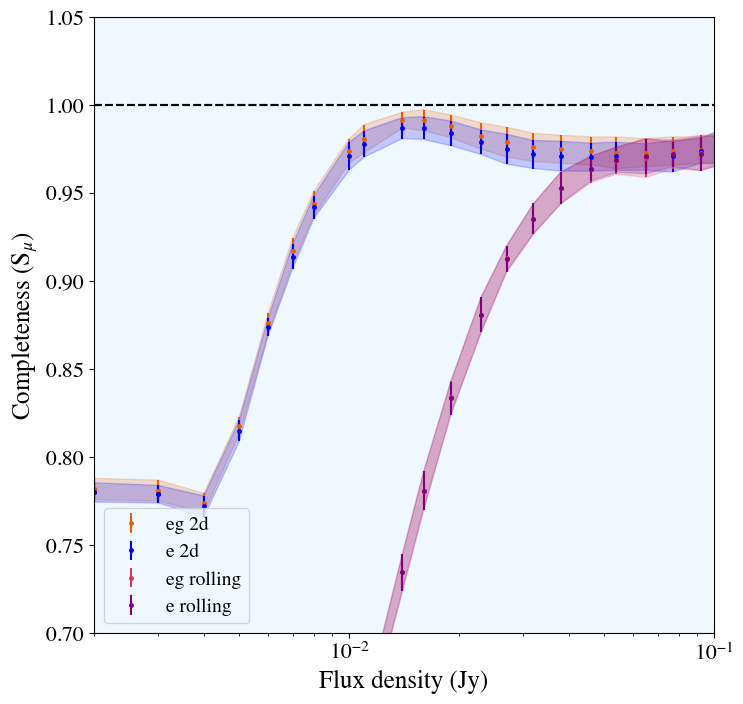

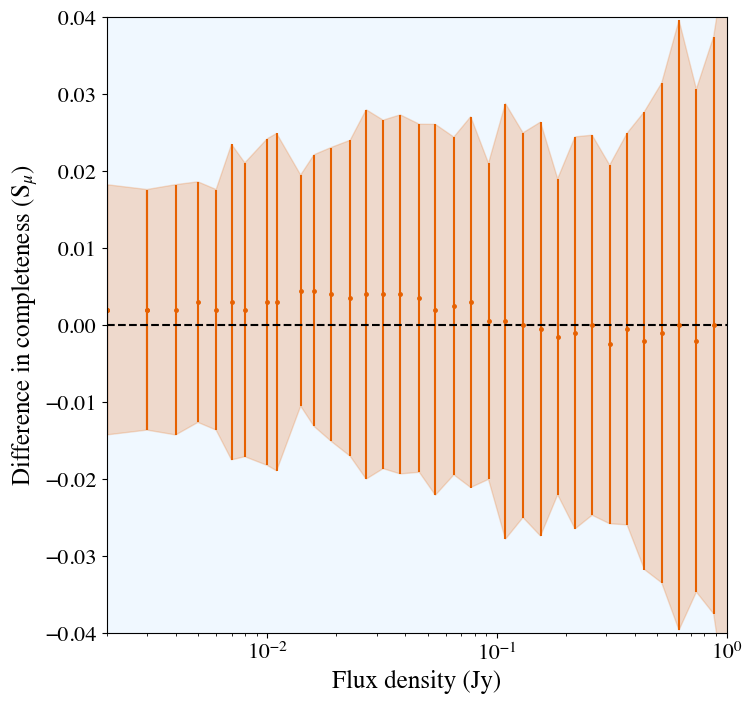

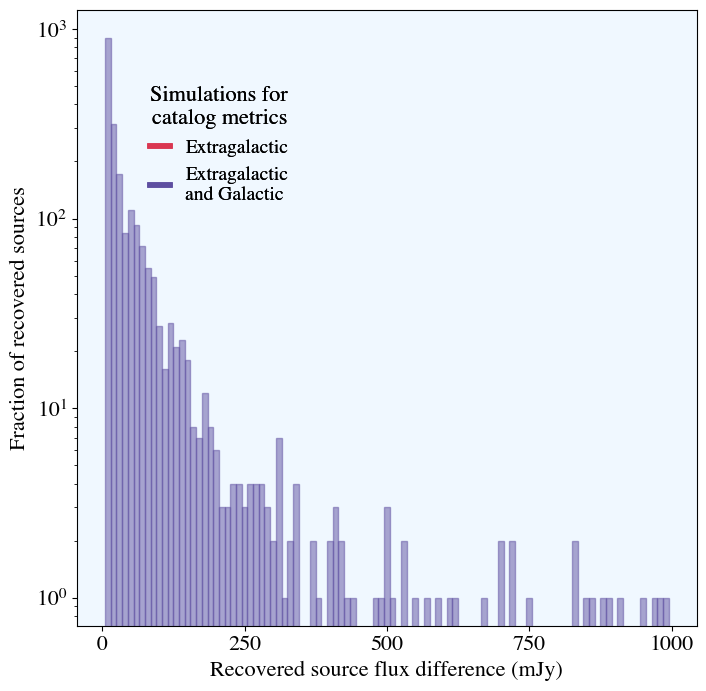

In [117]:

def error_diff(sigA, sigB):
    xx1 = (sigA**2.) + (sigB**2.)
    return np.sqrt(xx1)

def error_divs(sigA, sigB, A, B):
    xx1 = (sigA**2.) + (((A*sigB)/B)**2.)
    return (1./B)*np.sqrt(xx1)

def select_radius(table, pix_radius, ra_name, dec_name):
    wsclean_pix_per_deg = 0.004
    deg_radius = (wsclean_pix_per_deg * pix_radius)**2
    
    size = 8192
    wcs = WCS(f'/Users/nicholebarry/MWA/data/completeness_metric/eg_sim_zenith_{str(size)}_-MFS-image-pb.fits')
    origin = wcs.wcs_pix2world(np.array([[size/2, size/2,1,1]], dtype=np.float64),1)

    all_ra = table[ra_name]
    all_dec = table[dec_name]
    
    sub_inds = np.argwhere((all_ra > 180) & (all_ra < 360))
    all_ra[sub_inds] = all_ra[sub_inds] - 360
    
    all_ra = all_ra - origin[0,0]
    all_dec = all_dec - origin[0,1]
    
    dist_from_origin = all_ra**2 + all_dec**2
    
    keep_inds = np.argwhere(dist_from_origin < deg_radius)
    table = table[keep_inds]
    
    return table
    

def get_flux(rec_dir, name='crossmatch', ra='RA_1_1', dec='DEC_1_1'):    
    
    comp_cats = glob.glob(f'{rec_dir}/eg_and_e_{name}_*.fits')
    comp_cats.sort()
    
    for yy in range(len(comp_cats)):
        csrc_cat = comp_cats[yy]
        ctbl = Table.read(csrc_cat)
        ctbl = select_radius(ctbl, 4000, ra, dec)
        numr = len(ctbl[ra]) #or RA_1
        
        # Get fluxes of all recovered sources
        flx_esrc = np.zeros(numr)
        flx_egsrc = np.zeros(numr)
        flx_osrc = np.zeros(numr)
        
        if name == 'crossmatch':
            for zz in range(numr):
                flx_esrc[zz] = float(ctbl['Total_flux_2'][zz]) #found flux
                flx_egsrc[zz] = float(ctbl['Total_flux_1'][zz]) #true injected flux
                flx_osrc[zz] = float(ctbl['int_flux_1'][zz]) #true injected flux
        else:
            for zz in range(numr):
                flx_egsrc[zz] = float(ctbl['Total_flux'][zz]) #found flux
                flx_osrc[zz] = float(ctbl['int_flux'][zz]) #true injected flux
            
        if yy == 0:
            flx_orig = flx_osrc
            flx_egreco = flx_egsrc
            if name == 'crossmatch':
                flx_ereco = flx_esrc
        else:
            flx_orig = np.append(flx_orig, flx_osrc)
            flx_egreco = np.append(flx_egreco, flx_egsrc)
            if name == 'crossmatch':
                flx_ereco = np.append(flx_ereco, flx_esrc)
    
    if name == 'crossmatch':
        return flx_orig, flx_ereco, flx_egreco
    else:
        return flx_orig, flx_egreco

    
#####################################################################################################################



def calc_completeness(rec_dir, sim_dir, flx_bins):
    
    numf = len(flx_bins) - 1
    
    ##Find all recovered source fits tables
    rcvrd_cats = glob.glob(f'{rec_dir}/Recovered_S*.fits')
    rcvrd_cats.sort()
    
    ##Find all unmatched sources fits tables
    false_cats = glob.glob(f'{rec_dir}/Sources*.fits')
    false_cats.sort()

    num_recov = np.zeros(len(rcvrd_cats)*numf).reshape(len(rcvrd_cats), numf)
    num_injec = np.zeros(len(rcvrd_cats)*numf).reshape(len(rcvrd_cats), numf)
    num_false = np.zeros(len(rcvrd_cats)*numf).reshape(len(rcvrd_cats), numf)
    comp_vals = np.zeros(len(rcvrd_cats)*numf).reshape(len(rcvrd_cats), numf)
    fdr_vals = np.zeros(len(rcvrd_cats)*numf).reshape(len(rcvrd_cats), numf)
    rec_sum = np.zeros(len(rcvrd_cats)*numf).reshape(len(rcvrd_cats), numf)
    inject_sum = np.zeros(len(rcvrd_cats)*numf).reshape(len(rcvrd_cats), numf)
    
    all_diff_in_bin = np.zeros(numf)
    #print(len(rcvrd_cats))
    for yy in range(len(rcvrd_cats)):

        #### Recovered sources
        ####
        rsrc_cat = rcvrd_cats[yy]
        rtbl = Table.read(rsrc_cat)
        rtbl = select_radius(rtbl, 4000, 'RA_1', 'DEC_1')
        numr = len(rtbl['RA_1']) #or RA_1

        # Get fluxes of all recovered sources
        flx_rsrc = np.zeros(numr)
        flx_osrc = np.zeros(numr)
        for zz in range(numr):
            flx_rsrc[zz] = float(rtbl['Total_flux'][zz]) #found flux
            flx_osrc[zz] = float(rtbl['int_flux'][zz]) #true injected flux
        ####
        ####
            
        # Get simulation number for labeling    
        indx0 = rsrc_cat.find('1not2_')+6 #('1not2')+5
        indx1 = rsrc_cat.find('.fits')
        N = int(rsrc_cat[indx0:indx1]) #SIM NUMBER

        #### Injected sources
        ####
        #Read in injected source catalogue for this iteration
        sim_pos = f'{sim_dir}SimSources_Fluxes{str(N)}.fits' 
        stbl = Table.read(sim_pos)
        stbl = select_radius(stbl, 4000, 'ra', 'dec')
        #stbl.write(f'/Users/nicholebarry/MWA/data/completeness_metric/SimSources7000/SimSources_Fluxes{str(N)}_temp.fits',overwrite=True)
        nums = len(stbl['ra'])
        #print(numr, nums)

        #Get fluxes of original injected sources
        flx_sim = np.zeros(nums)
        for zz in range(nums):
            flx_sim[zz] = float(stbl['int_flux'][zz])
        ####
        ####
          
        #### False sources 
        ####
        fsrc_cat = false_cats[yy]
        ftbl = Table.read(fsrc_cat)
        ftbl = select_radius(ftbl, 4000, 'RA', 'DEC')
        numfalse = len(ftbl['RA']) #or RA_1
        
        #Get fluxes of false sources
        flx_fsrc = np.zeros(numfalse)
        for zz in range(numfalse):
            flx_fsrc[zz] = float(ftbl['Total_flux'][zz])
        ####
        ####
        
        hflx_rsrc, hflx_rsrc_b = np.histogram(flx_rsrc, bins=flx_bins) #histogram recovered source fluxes
        hflx_sim, hflx_sim_b = np.histogram(flx_sim, bins=flx_bins) #histogram sim injected source fluxes
        hflx_fsrc, hflx_fsrc_b = np.histogram(flx_fsrc, bins=flx_bins) #histogram false source fluxes
        
        if yy == 0:
            flx_diff = flx_rsrc - flx_osrc
            flx_orig = flx_osrc
            flx_reco = flx_rsrc
        else:
            flx_diff = np.append(flx_diff, flx_rsrc - flx_osrc)
            flx_orig = np.append(flx_orig, flx_osrc)
            flx_orig = np.append(flx_reco, flx_rsrc)
        
        #For each flux bin, get the total number of recovered, injected
        for b in range(numf):

            indx_src_in_bin = np.argwhere((flx_osrc > flx_bins[b]) & (flx_osrc < flx_bins[b+1]))
            diff_in_bin = flx_osrc[indx_src_in_bin] - flx_rsrc[indx_src_in_bin]
            
            tot_rsrc = float(hflx_rsrc[b]) #number of sim image sources in flux bin
            tot_sim = float(hflx_sim[b]) #number injected sources in flux bin
            tot_fsrc = float(hflx_fsrc[b]) #number false sources in flux bin
            
#             all_diff_in_bin[b] = np.append(all_diff_in_bin[b], diff_in_bin)
#             if b == 20:
#                 print(all_diff_in_bin[b])
                
            num_recov[yy, b] = tot_rsrc
            num_injec[yy, b] = tot_sim
            num_false[yy, b] = tot_fsrc
            #num_diff[yy, b] = tot_diff

        #Sum each flux bin before to get a running total
        for bb in range(numf):

            sum_recov = 0
            sum_injec = 0
            sum_false = 0
            #Get all bins above 
            for aa in range(bb, numf):
                sum_recov += num_recov[yy, aa]
                sum_injec += num_injec[yy, aa]
                sum_false += num_false[yy, aa]

            if sum_injec == 0:
                comp_vals[yy, bb] = np.nan

            else:
                comp_vals[yy, bb] = np.around(sum_recov/sum_injec, decimals=3)
                #comp_vals[yy, bb] = np.around(num_recov[yy, bb]/num_injec[yy, bb], decimals=5)
                fdr_vals[yy, bb] = sum_false
                rec_sum[yy, bb] = sum_recov
                inject_sum[yy, bb] = sum_injec


    med_comp = np.zeros(numf)
    err_comp_16 = np.zeros(numf)
    err_comp_84 = np.zeros(numf)

    for yy in range(numf):
        med_comp[yy] = np.nanmedian(comp_vals[:, yy])
        #print(np.nanmedian(num_false[:, yy]))
        #print(np.nanmedian(rec_sum[:, yy]), np.nanmedian(inject_sum[:, yy]))
        perc = np.nanpercentile(comp_vals[:, yy], [16, 84]) 
        err_comp_84[yy] = perc[1] - med_comp[yy]



    #print(flx_bins[:-1])
    #print()
    #print(err_comp_84)
    #print(med_comp) # median of the sum of recovered sources over the sum of the injected sources

    return med_comp, err_comp_84, flx_diff, flx_orig, flx_reco


#flux bins to use for plotting/histograming
flx_bins = np.around(np.logspace(np.log10(0.001), np.log10(5), num=50), decimals=3)
numf = len(flx_bins) - 1

rec_dir = '/Users/nicholebarry/MWA/data/completeness_metric/eg_recovered7000_rolling/'
sim_dir = '/Users/nicholebarry/MWA/data/completeness_metric/SimSources7000_rolling/'
med_comp_eg, err_comp_84_eg, flx_diff_eg, flx_orig_eg, flx_reco_eg = calc_completeness(rec_dir, sim_dir, flx_bins)

rec_dir = '/Users/nicholebarry/MWA/data/completeness_metric/e_recovered7000_rolling/'
med_comp_e, err_comp_84_e, flx_diff_e, flx_orig_e, flx_reco_e = calc_completeness(rec_dir, sim_dir, flx_bins)

diff_med_comp = med_comp_eg - med_comp_e
diff_err_comp = error_diff(2*err_comp_84_eg, 2*err_comp_84_e)
print(len(flx_diff_e),len(flx_diff_eg))
print(diff_med_comp)


rec_dir = '/Users/nicholebarry/MWA/data/completeness_metric/eg_recovered7000_2d/'
sim_dir = '/Users/nicholebarry/MWA/data/completeness_metric/SimSources7000_2d/'
med_comp_eg_rl, err_comp_84_eg_rl, flx_diff_eg_rl, flx_orig_eg_rl, flx_reco_eg_rl = calc_completeness(rec_dir, sim_dir, flx_bins)

rec_dir = '/Users/nicholebarry/MWA/data/completeness_metric/e_recovered7000_2d/'
med_comp_e_rl, err_comp_84_e_rl, flx_diff_e_rl, flx_orig_e_rl, flx_reco_e_rl = calc_completeness(rec_dir, sim_dir, flx_bins)

rec_dir = '/Users/nicholebarry/MWA/data/completeness_metric/eg_and_e_compare_recovered7000_rolling/'
flx_orig, flx_ereco, flx_egreco = get_flux(rec_dir)

rec_dir = '/Users/nicholebarry/MWA/data/completeness_metric/eg_and_e_compare_recovered7000_flat/'
flx_orig_flat, flx_ereco_flat, flx_egreco_flat = get_flux(rec_dir)

rec_dir = '/Users/nicholebarry/MWA/data/completeness_metric/eg_and_e_compare_recovered7000_rolling/'
flx_orig_1not2, flx_egreco_1not2 = get_flux(rec_dir, name='1not2', ra='RA_1', dec='DEC_1')

rec_dir = '/Users/nicholebarry/MWA/data/completeness_metric/eg_and_e_compare_recovered7000_rolling/'
flx_orig_2not1, flx_ereco_2not1 = get_flux(rec_dir, name='2not1', ra='RA_1', dec='DEC_1')


diff_med_comp_rl = med_comp_eg_rl - med_comp_e_rl
diff_err_comp_rl = error_diff(2*err_comp_84_eg_rl, 2*err_comp_84_e_rl)
print(len(flx_diff_e_rl),len(flx_diff_eg_rl))

# med_fdr = np.zeros(numf)
# err_fdr_84 = np.zeros(numf)

# for yy in range(numf):
#     med_fdr[yy] = np.nanmedian(fdr_vals[:, yy])
#     perc = np.nanpercentile(fdr_vals[:, yy], [16, 84]) 
#     err_fdr_84[yy] = perc[1] - med_fdr[yy]

#print(med_comp_eg_2d,med_comp_e_2d)
fig, ax = plt.subplots(1,1, figsize=(8,8) )
ax.errorbar(flx_bins[:-1], med_comp_eg, yerr=err_comp_84_eg, marker='.', ms=5.0, color='#e66101', linestyle='None', label='eg 2d')
ax.fill_between(flx_bins[:-1], med_comp_eg-err_comp_84_eg, med_comp_eg+err_comp_84_eg,
    alpha=0.2, edgecolor='#e66101', facecolor='#e66101',
    linewidth=1, antialiased=True)
ax.errorbar(flx_bins[:-1], med_comp_e, yerr=err_comp_84_e, marker='.', ms=5.0, color='blue', linestyle='None', label='e 2d')
ax.fill_between(flx_bins[:-1], med_comp_e-err_comp_84_e, med_comp_e+err_comp_84_e,
    alpha=0.2, edgecolor='blue', facecolor='blue',
    linewidth=1, antialiased=True)
ax.axhline(1.0, 0., 15, linestyle='--', color='k')
ax.set_xscale("log")
ax.set_ylim(0.7, 1.05)
ax.set_xlim(0.002, .1)
ax.set_xlabel('Flux density (Jy)', fontsize=18.)
ax.set_ylabel('Completeness (S$_\mu$)', fontsize=18.)
#plt.legend(fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
#plt.savefig('/Users/nicholebarry/MWA/data/completeness_metric/SRC_COUNT_Corrections_eg_2d.png', bbox_inches='tight')

hist_color=['j','e']

#print(med_comp_eg_rl,med_comp_e_rl)
#fig, ax = plt.subplots(1,1, figsize=(8,8) )
ax.errorbar(flx_bins[:-1], med_comp_eg_rl, yerr=err_comp_84_eg_rl, marker='.', ms=5.0, color=hist_color[0], linestyle='None', label='eg rolling')
ax.fill_between(flx_bins[:-1], med_comp_eg_rl-err_comp_84_eg_rl, med_comp_eg_rl+err_comp_84_eg_rl,
    alpha=0.2, edgecolor=hist_color[0], facecolor=hist_color[0],
    linewidth=1, antialiased=True)
ax.errorbar(flx_bins[:-1], med_comp_e_rl, yerr=err_comp_84_e_rl, marker='.', ms=5.0, color='purple', linestyle='None', label='e rolling')
ax.fill_between(flx_bins[:-1], med_comp_e_rl-err_comp_84_e_rl, med_comp_e_rl+err_comp_84_e_rl,
    alpha=0.2, edgecolor='purple', facecolor='purple',
    linewidth=1, antialiased=True)
ax.axhline(1.0, 0., 15, linestyle='--', color='k')
ax.set_xscale("log")
#ax.set_ylim(0.4, 1.2)
#ax.set_xlim(0.004, 11)
#ax.set_xlabel('Flux density (Jy)', fontsize=18.)
#ax.set_ylabel('Completeness (S$_\mu$)', fontsize=18.)
plt.legend(fontsize=14)
#plt.setp(ax.get_xticklabels(), fontsize=16)
#plt.setp(ax.get_yticklabels(), fontsize=16)
plt.savefig('/Users/nicholebarry/MWA/data/completeness_metric/SRC_COUNT_Corrections_eg_4096_2d.png', bbox_inches='tight')



fig, ax = plt.subplots(1,1, figsize=(8,8) )
ax.errorbar(flx_bins[:-1], diff_med_comp, yerr=diff_err_comp, marker='.', ms=5.0, color='#e66101', linestyle='None', label='eg 2d')
ax.fill_between(flx_bins[:-1], diff_med_comp-diff_err_comp, diff_med_comp+diff_err_comp,
    alpha=0.2, edgecolor='#e66101', facecolor='#e66101',
    linewidth=1, antialiased=True)
ax.axhline(0, 0., 15, linestyle='--', color='k')
ax.set_xscale("log")
ax.set_ylim(-0.04, 0.04)
ax.set_xlim(0.002, 1)
ax.set_xlabel('Flux density (Jy)', fontsize=18.)
ax.set_ylabel('Difference in completeness (S$_\mu$)', fontsize=18.)
#plt.legend(fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
#plt.savefig('/Users/nicholebarry/MWA/data/completeness_metric/SRC_COUNT_Corrections_eg_2d.png', bbox_inches='tight')
plt.savefig('/Users/nicholebarry/MWA/data/completeness_metric/Completeness_diff_roll.png', bbox_inches='tight')





# Binsize for all histograms
fig, ax = plt.subplots(1,1, figsize=(8,8) )
bins = np.arange(0, 1000, 10)                    
hist_e, bin_edges = np.histogram((flx_diff_e*1000), bins=bins)

hist_e_orig, bin_edges = np.histogram((flx_orig_e*1000), bins=bins)
hist_eg_orig, bin_edges = np.histogram((flx_orig_eg*1000), bins=bins)
hist_e_reco, bin_edges = np.histogram((flx_reco_e*1000), bins=bins)
hist_eg_reco, bin_edges = np.histogram((flx_reco_eg*1000), bins=bins)

hist_diff, bin_edges = np.histogram(((flx_ereco - flx_egreco)*1000), bins=bins)
hist_diff_egreco, bin_edges = np.histogram(((flx_egreco - flx_orig)*1000), bins=bins)
hist_diff_ereco, bin_edges = np.histogram(((flx_ereco - flx_orig)*1000), bins=bins)
hist_diff_e_dist_eg, bin_edges = np.histogram( (np.abs(flx_ereco - flx_orig) - np.abs(flx_egreco - flx_orig))*1000, bins=bins)

hist_diff_egreco_flat, bin_edges = np.histogram(((flx_egreco_flat - flx_orig_flat)*1000), bins=bins)
hist_diff_ereco_flat, bin_edges = np.histogram(((flx_ereco_flat - flx_orig_flat)*1000), bins=bins)
hist_diff_flat, bin_edges = np.histogram(((flx_ereco_flat - flx_egreco_flat)*1000), bins=bins)

hist_1not2, bin_edges = np.histogram((flx_egreco_1not2*1000), bins=bins)

faint_inds = np.argwhere(flx_orig > 1)
print(len(faint_inds))
hist_diff_e_dist_eg_faint, bin_edges = np.histogram( 
    (np.abs(flx_ereco[faint_inds] - flx_orig[faint_inds]) - np.abs(flx_egreco[faint_inds] - flx_orig[faint_inds]))*1000, bins=bins)



(mu_flx_diff_e, sigma_flx_diff_e) = norm.fit(flx_diff_e*1000)
width = (bin_edges[1]- bin_edges[0])
#plt.bar(bin_edges[1:], (hist_e/len(flx_diff_e))*100, width=width, color=hist_color[0], alpha = 0.5, edgecolor=hist_color[0], linewidth=1)
hist_eg, bin_edges = np.histogram((flx_diff_eg*1000), bins=bins)
(mu_flx_diff_eg, sigma_flx_diff_eg) = norm.fit(flx_diff_eg*1000)

width = (bin_edges[1]- bin_edges[0])
#plt.bar(bin_edges[1:], (hist_eg/len(flx_diff_eg))*100, width=width, color=hist_color[1], alpha = 0.5, edgecolor=hist_color[1], linewidth=1)
#plt.bar(bin_edges[1:], (hist_e/len(flx_diff_e) - hist_eg/len(flx_diff_eg)), width=width, color=hist_color[1], alpha = 0.5, edgecolor=hist_color[1], linewidth=1)
#plt.bar(bin_edges[1:], (hist_e - hist_eg), width=width, color=hist_color[1], alpha = 0.5, edgecolor=hist_color[1], linewidth=1)

#plt.bar(bin_edges[1:], hist_diff / len(flx_ereco), width=width, color=hist_color[1], alpha = 0.5, edgecolor=hist_color[1], linewidth=1)
#plt.bar(bin_edges[1:], hist_diff_ereco - hist_diff_egreco, width=width, color=hist_color[0], alpha = 0.5, edgecolor=hist_color[1], linewidth=1)
# positive says that e was brighter than the original sources than eg was, negative says that eg was brighter than the original sources than e was

#plt.bar(bin_edges[1:], hist_diff_e_dist_eg / len(flx_ereco), width=width, color=hist_color[0], alpha = 0.5, edgecolor=hist_color[1], linewidth=1)
# positive says that e has a greater distance, negative says that eg has a greater distance

# plt.bar(bin_edges[1:], hist_diff_e_dist_eg_faint / len(flx_ereco[faint_inds]), width=width, color=hist_color[0], alpha = 0.5, edgecolor=hist_color[1], linewidth=1)
# # positive says that e has a greater distance, negative says that eg has a greater distance
# (mu_flx_dist, sigma_flx_dist) = norm.fit((np.abs(flx_ereco[faint_inds] - flx_orig[faint_inds]) - np.abs(flx_egreco[faint_inds] - flx_orig[faint_inds]))*1000)
# print(mu_flx_dist, sigma_flx_dist)

# plt.bar(bin_edges[1:], hist_diff_ereco_flat / len(flx_orig_flat), width=width, color=hist_color[0], alpha = 0.5, edgecolor=hist_color[0], linewidth=1)
# plt.bar(bin_edges[1:], hist_diff_egreco_flat / len(flx_orig_flat), width=width, color=hist_color[1], alpha = 0.5, edgecolor=hist_color[1], linewidth=1)
#plt.bar(bin_edges[1:], hist_diff_flat / len(flx_orig_flat), width=width, color=hist_color[1], alpha = 0.5, edgecolor=hist_color[1], linewidth=1)
#if positive, then e is brighter. if negative, then eg is brighter
(mu_flx_diff_e_flat, sigma_flx_diff_e_flat) = norm.fit(((flx_ereco_flat - flx_orig_flat)*1000))
(mu_flx_diff_eg_flat, sigma_flx_diff_eg_flat) = norm.fit(((flx_egreco_flat - flx_orig_flat)*1000))
print(mu_flx_diff_e_flat, sigma_flx_diff_e_flat)
print(mu_flx_diff_eg_flat, sigma_flx_diff_eg_flat)

(mu_flx_diff_e, sigma_flx_diff_e) = norm.fit((flx_ereco - flx_orig)*1000)
(mu_flx_diff_eg, sigma_flx_diff_eg) = norm.fit((flx_egreco - flx_orig)*1000)
print(mu_flx_diff_e, sigma_flx_diff_e) # if mu is pos, then e was too bright, if mu is negative, then e was not bright enough. sigma and mu as close to 0 desired
print(mu_flx_diff_eg, sigma_flx_diff_eg)

plt.bar(bin_edges[1:], hist_1not2, width=width, color=hist_color[1], alpha = 0.5, edgecolor=hist_color[1], linewidth=1)
print(len(flx_egreco_1not2))
faint_inds = np.argwhere(flx_egreco_1not2 < .2)
print(len(faint_inds)/len(flx_egreco_1not2))
print(len(flx_ereco_2not1))


ax.set_yscale("log")
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
#plt.xlim([-400,400])
#plt.ylim([.001,20])
plt.xlabel('Recovered source flux difference (mJy)',fontsize=16)
plt.ylabel('Fraction of recovered sources',fontsize=16)

#print(mu_flx_diff_e, sigma_flx_diff_e)
#print(mu_flx_diff_eg, sigma_flx_diff_eg)

# Legend
f1_label = ['Extragalactic', 'Extragalactic\nand Galactic']
patches = [ plt.plot([],[], mec=None, color=hist_color[type_i],
            label="{:s}".format(f1_label[type_i]) )[0]  for type_i in range(len(f1_label)) ]
legend2 = plt.legend(handles=patches, bbox_to_anchor=(0.23, 0.78),loc='center', ncol=1, frameon=False,
                    fontsize=14,title_fontsize=16,handlelength=1)
legend2._legend_box.align='left'
legend2.set_title(title="Simulations for\ncatalog metrics") 
legend2.get_title().set_multialignment('center')
# change the line width for the legend
for line in legend2.get_lines():
    line.set_linewidth(4.0)
a2=plt.gca()
a2.add_artist(legend2)

plt.savefig('/Users/nicholebarry/MWA/data/completeness_metric/flx_diff_4096_2d.png',bbox_inches='tight')




7711
7702


<BarContainer object of 49 artists>

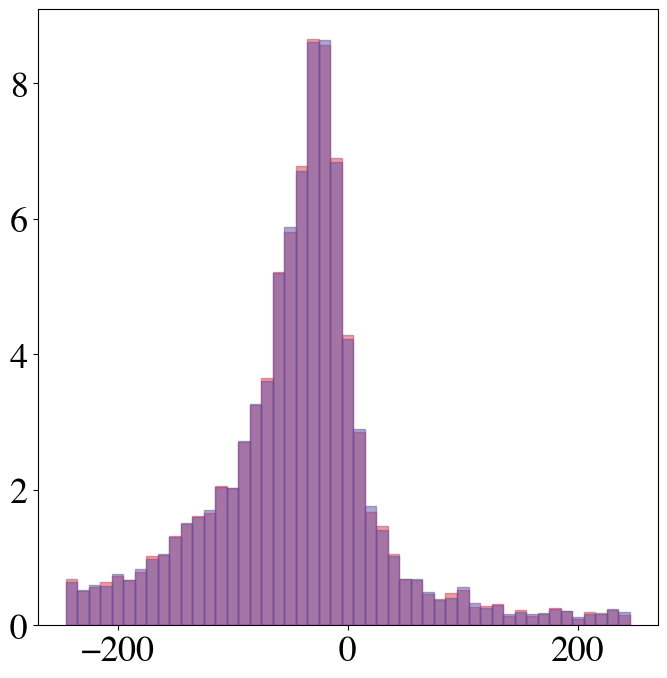

In [9]:

from scipy.stats import kurtosis
from scipy.stats import skew

def error_diff(sigA, sigB):
    xx1 = (sigA**2.) + (sigB**2.)
    return np.sqrt(xx1)

def error_divs(sigA, sigB, A, B):
    xx1 = (sigA**2.) + (((A*sigB)/B)**2.)
    return (1./B)*np.sqrt(xx1)

#####################################################################################################################

def calc_completeness(rec_dir): 

    #### Recovered sources
    ####
    rtbl = Table.read(f'{rec_dir}')
    rtbl = select_radius(rtbl, 4000, 'RA_1', 'DEC_1')
    numr = len(rtbl['RA_1']) #or RA_1

    # Get fluxes of all recovered sources
    flx_rsrc = np.zeros(numr)
    flx_osrc = np.zeros(numr)
    for zz in range(numr):
        flx_rsrc[zz] = float(rtbl['Total_flux'][zz]) #or INT_FLUX
        flx_osrc[zz] = float(rtbl['INT_FLX181'][zz])
    ####
    ####
     
    flx_diff = flx_rsrc - flx_osrc

    return flx_diff



rec_dir = '/Users/nicholebarry/MWA/data/completeness_metric/eg_XmatchCat_OImg_LoBES_OPos_xmatch_best2.fits'
#rec_dir = '/Users/nicholebarry/MWA/data/completeness_metric/eg_XmatchCat_OImg_LoBES_OPos_xmatch_1not2.fits'
flx_diff_eg = calc_completeness(rec_dir)

rec_dir = '/Users/nicholebarry/MWA/data/completeness_metric/e_XmatchCat_OImg_LoBES_OPos_xmatch_best2.fits'
#rec_dir = '/Users/nicholebarry/MWA/data/completeness_metric/e_XmatchCat_OImg_LoBES_OPos_xmatch_1not2.fits'
flx_diff_e = calc_completeness(rec_dir)


fig, ax = plt.subplots(1,1, figsize=(8,8) )
bins = np.arange(-250, 250, 10)                    
hist_e, bin_edges = np.histogram((flx_diff_e*1000), bins=bins)
print(len(flx_diff_e))
(mu_flx_diff_e, sigma_flx_diff_e) = norm.fit(flx_diff_e*1000)
width = (bin_edges[1]- bin_edges[0])
plt.bar(bin_edges[1:], (hist_e/len(flx_diff_e))*100, width=width, color=hist_color[0], alpha = 0.5, edgecolor=hist_color[0], linewidth=1)
hist_eg, bin_edges = np.histogram((flx_diff_eg*1000), bins=bins)
(mu_flx_diff_eg, sigma_flx_diff_eg) = norm.fit(flx_diff_eg*1000)
print(len(flx_diff_eg))
width = (bin_edges[1]- bin_edges[0])
plt.bar(bin_edges[1:], (hist_eg/len(flx_diff_eg))*100, width=width, color=hist_color[1], alpha = 0.5, edgecolor=hist_color[1], linewidth=1)
#plt.bar(bin_edges[1:], (hist_eg/len(flx_diff_eg) - hist_e/len(flx_diff_e))*100, width=width, color=hist_color[1], alpha = 0.5, edgecolor=hist_color[1], linewidth=1)






In [16]:
####### Presentation from FIGURE 2
## Plot of the difference in data with removing galaxy and the beam improvement for use in a gif

def plot_defaults(f, data, cmap, vmin, vmax, xtext, ytext, fontsize=26):

    f.show_colorscale(cmap=cmap, stretch='linear',vmin=vmin,vmax=vmax)
    f.set_nan_color('cadetblue')
    f.show_contour(np.abs(data), levels=[0.00000001],colors='white')
    
    f.axis_labels.set_ytext(ytext)
    f.axis_labels.set_xtext(xtext)
    f.tick_labels.set_xformat('dd')
    f.tick_labels.set_font(size=18)
    f.axis_labels.set_font(size=fontsize)
    f.ticks.set_yspacing(10)
    f.ticks.set_xspacing(40)
    f.ticks.hide()
    f.tick_labels.hide()
    f.add_grid()
    
    return
    
def plot_dataimprovement(files, cmap=cb_spec, vmin=None, vmax=None, imsz=None, width=None, \
                             savepdf=False, savefig=False, fontsize=None, figname=''):
    
    ## Set file names to expected input order
    # e: extragalactic removed, g: galactic removed
    fitsfile_e_yy = files
    ##
    
    ## Read in data/hdr from each file
    _info = get_fitsinfo(fitsfile_e_yy)
    data_e_yy_pre = _info['data']
    fitsfile_e_yy = str_to_pixel(fitsfile_e_yy)
    _info = get_fitsinfo(fitsfile_e_yy)
    hdr_e_yy = _info['hdr']
    data_e_yy = _info['data']
    
    ##
    
    fig = plt.figure(figsize=(21,21))
    xmin=.1
    ymin=.1
    ymax = .9
    yspace = imsz/180 #114/180 *1.1/3
    xspace = width/180 #114/180 *3/4
    title_pad=26 #in points
    fontsize=36
    #[left, bottom, width, height]
    subplot_loc_1 = [xmin,ymax,xspace*2,yspace*2]
    
    center_x = hdr_e_yy['CRVAL1']
    center_y = hdr_e_yy['CRVAL2']+2
    ##
    
    ##### Images

    ## First plot in panel: extragalactic removed N-S polarisation
    f1 = aplpy.FITSFigure(fitsfile_e_yy, figure=fig, subplot=subplot_loc_1)
    f1.recenter(center_x, center_y, height=imsz, width=width)
    plot_defaults(f1, data_e_yy, cmap, vmin, vmax, 'Right Ascension', 'Declination', fontsize=fontsize)
    f1.show_contour(np.abs(data_e_yy_pre), levels=[0.00000001],colors='ghostwhite',linestyle=4)
    f1.set_title('N$\endash$S polarization\nLST 359.8 (deg)',pad=title_pad,fontproperties=font_bold)
    ##
    
    ## Image color bar, initialised in first block on notebook
    #[left, bottom, width, height]
    cbar_ax = fig.add_axes([xspace*2+xmin+0.015, ymax, 0.015, yspace*2])
    cbar = pl.colorbar(colorbar_scale_data, cax=cbar_ax,orientation="vertical")
    cbar_ax.invert_xaxis()
    cbar.set_label(label='Brightness (mJy/pixel)',size=fontsize,fontproperties=font)
    for tick in cbar_ax.xaxis.majorTicks:
        tick.label1.set_fontproperties(font)
    cbar_ax.tick_params(labelsize=fontsize)
    ##
    
    plt.tight_layout()

    if savefig:
        if savepdf:
            pp = PdfPages(figname + '.pdf')
            pp.savefig()
            pp.close()
        else:
            plt.savefig(figname, bbox_inches='tight', dpi=300)
            plt.close()
    else:
        plt.show()


dir_plt1 = '/Users/nicholebarry/MWA/data/fits_iamges/beam_showcase/'
dir_plt2 = '/Users/nicholebarry/MWA/data/fits_iamges/data_galaxy_removal/'

files = [dir_plt1 + '1088285600_uniform_Residual_YY.fregbeam.fits',\
         dir_plt2 + 'yy/extragalactic/1088285600_uniform_Residual_YY.fits']
         #dir_plt + '3072/extragalactic/1088281088_robust1_Residual_XX.fits',\
         #dir_plt + '3072/galactic_extragalactic/1088281088_robust1_Residual_XX.fits']

plot_dataimprovement(files[0], vmax=10,vmin=-10,imsz=114/2, width=114, fontsize=26, \
                     savefig=True,figname=dir_plt1 + 'regbeam')
plot_dataimprovement(files[1], vmax=10,vmin=-10,imsz=114/2, width=114, fontsize=26, \
                     savefig=True,figname=dir_plt1 + 'gaussbeam')


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/Users/nicholebarry/miniconda3/envs/python_graphics/lib/python3.11/site-packages/astropy/visualization/wcsaxes/core.py:257: UserWarning: The following kwargs were not used by contour: 'linestyle'
  cset = super().contour(*args, **kwargs)
/var/folders/bq/wmsr1m_d2c94qwkmz9xyr3g80000gn/T/ipykernel_4423/3479377837.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/Users/nicholebarry/miniconda3/envs/python_graphics/lib/python3.11/site-packages/astropy/visualization/wcsaxes/core.py:257: UserWarning: The following kwargs were not used by contour: 'linestyle'
  cset = super().contour(*args, **kwargs)
/var/folders/bq/wmsr1m_d2c94qwkmz9xyr3g80000gn/T/ipykernel_4423/3479377837.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so resul